In [1]:
import os
import re
import numpy as np
import time
import random
import pandas as pd
import glob
import shutil
import seaborn as sns
import itertools
import math
from pathlib import Path
import json
from copy import deepcopy
from dataclasses import dataclass
from types import SimpleNamespace

from matplotlib.lines import Line2D
from scipy.integrate import solve_ivp
from sklearn.metrics import confusion_matrix
from autocatalytic_cores_lib import *
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sympy import symbols, Matrix, diff, lambdify
from scipy.linalg import eigvals
from numpy.linalg import svd
from scipy.optimize import linprog
from scipy.sparse import csr_matrix
from scipy.sparse import bmat
from scipy.sparse.csgraph import connected_components
from scipy.linalg import eigh
from scipy.optimize import fsolve
from textwrap import dedent
import networkx as nx   
from matplotlib import animation

In [2]:
'''
Try to build scalable networks
'''

'\nTry to build scalable networks\n'

In [3]:
class Neumann(object):

    """
    This class describes the Generalized von Neumann growth model as it was
    discussed in Kemeny et al. (1956, ECTA) and Gale (1960, Chapter 9.5):

    Let:
    n ... number of goods
    m ... number of activities
    A ... input matrix is m-by-n
        a_{i,j} - amount of good j consumed by activity i
    B ... output matrix is m-by-n
        b_{i,j} - amount of good j produced by activity i

    x ... intensity vector (m-vector) with non-negative entries
        x'B - the vector of goods produced
        x'A - the vector of goods consumed
    p ... price vector (n-vector) with non-negative entries
        Bp - the revenue vector for every activity
        Ap - the cost of each activity

    Both A and B have non-negative entries. Moreover, we assume that
    (1) Assumption I (every good which is consumed is also produced):
        for all j, b_{.,j} > 0, i.e. at least one entry is strictly positive
    (2) Assumption II (no free lunch):
        for all i, a_{i,.} > 0, i.e. at least one entry is strictly positive

    Parameters
    ----------
    A : array_like or scalar(float)
        Part of the state transition equation.  It should be `n x n`
    B : array_like or scalar(float)
        Part of the state transition equation.  It should be `n x k`
    """

    def __init__(self, A, B):

        self.A, self.B = list(map(self.convert, (A, B)))
        self.m, self.n = self.A.shape

        # Check if (A, B) satisfy the basic assumptions
        assert self.A.shape == self.B.shape, 'The input and output matrices \
              must have the same dimensions!'
        assert (self.A >= 0).all() and (self.B >= 0).all(), 'The input and \
              output matrices must have only non-negative entries!'

        # (1) Check whether Assumption I is satisfied:
        if (np.sum(B, 0) <= 0).any():
            self.AI = False
        else:
            self.AI = True

        # (2) Check whether Assumption II is satisfied:
        if (np.sum(A, 1) <= 0).any():
            self.AII = False
        else:
            self.AII = True

    def __repr__(self):
        return self.__str__()

    def __str__(self):

        me = """
        Generalized von Neumann expanding model:
          - number of goods          : {n}
          - number of activities     : {m}

        Assumptions:
          - AI:  every column of B has a positive entry    : {AI}
          - AII: every row of A has a positive entry       : {AII}

        """
        # Irreducible                                       : {irr}
        return dedent(me.format(n=self.n, m=self.m,
                                AI=self.AI, AII=self.AII))

    def convert(self, x):
        """
        Convert array_like objects (lists of lists, floats, etc.) into
        well-formed 2D NumPy arrays
        """
        return np.atleast_2d(np.asarray(x))


    def bounds(self):
        """
        Calculate the trivial upper and lower bounds for alpha (expansion rate)
        and beta (interest factor). See the proof of Theorem 9.8 in Gale (1960)
        """

        n, m = self.n, self.m
        A, B = self.A, self.B

        f = lambda α: ((B - α * A) @ np.ones((n, 1))).max()
        g = lambda β: (np.ones((1, m)) @ (B - β * A)).min()

        UB = fsolve(f, 1).item()  # Upper bound for α, β
        LB = fsolve(g, 2).item()  # Lower bound for α, β

        return LB, UB


    def zerosum(self, γ, dual=False):
        """
        Given gamma, calculate the value and optimal strategies of a
        two-player zero-sum game given by the matrix

                M(gamma) = B - gamma * A

        Row player maximizing, column player minimizing

        Zero-sum game as an LP (primal --> α)

            max (0', 1) @ (x', v)
            subject to
            [-M', ones(n, 1)] @ (x', v)' <= 0
            (x', v) @ (ones(m, 1), 0) = 1
            (x', v) >= (0', -inf)

        Zero-sum game as an LP (dual --> beta)

            min (0', 1) @ (p', u)
            subject to
            [M, -ones(m, 1)] @ (p', u)' <= 0
            (p', u) @ (ones(n, 1), 0) = 1
            (p', u) >= (0', -inf)

        Outputs:
        --------
        value: scalar
            value of the zero-sum game

        strategy: vector
            if dual = False, it is the intensity vector,
            if dual = True, it is the price vector
        """

        A, B, n, m = self.A, self.B, self.n, self.m
        M = B - γ * A

        if dual == False:
            # Solve the primal LP (for details see the description)
            # (1) Define the problem for v as a maximization (linprog minimizes)
            c = np.hstack([np.zeros(m), -1])

            # (2) Add constraints :
            # ... non-negativity constraints
            bounds = tuple(m * [(0, None)] + [(None, None)])
            # ... inequality constraints
            A_iq = np.hstack([-M.T, np.ones((n, 1))])
            b_iq = np.zeros((n, 1))
            # ... normalization
            A_eq = np.hstack([np.ones(m), 0]).reshape(1, m + 1)
            b_eq = 1

            res = linprog(c, A_ub=A_iq, b_ub=b_iq, A_eq=A_eq, b_eq=b_eq,
                          bounds=bounds)

        else:
            # Solve the dual LP (for details see the description)
            # (1) Define the problem for v as a maximization (linprog minimizes)
            c = np.hstack([np.zeros(n), 1])

            # (2) Add constraints :
            # ... non-negativity constraints
            bounds = tuple(n * [(0, None)] + [(None, None)])
            # ... inequality constraints
            A_iq = np.hstack([M, -np.ones((m, 1))])
            b_iq = np.zeros((m, 1))
            # ... normalization
            A_eq = np.hstack([np.ones(n), 0]).reshape(1, n + 1)
            b_eq = 1

            res = linprog(c, A_ub=A_iq, b_ub=b_iq, A_eq=A_eq, b_eq=b_eq,
                          bounds=bounds)

        if res.status != 0 or res.x is None:
            # LP infeasible or error
            return np.nan, None

        # Pull out the required quantities
        value = res.x[-1]
        strategy = res.x[:-1]

        return value, strategy


    def expansion(self, tol=1e-8, maxit=1000):
        """
        The algorithm used here is described in Hamburger-Thompson-Weil
        (1967, ECTA). It is based on a simple bisection argument and utilizes
        the idea that for a given γ (= α or β), the matrix "M = B - γ * A"
        defines a two-player zero-sum game, where the optimal strategies are
        the (normalized) intensity and price vector.

        Outputs:
        --------
        alpha: scalar
            optimal expansion rate
        """

        LB, UB = self.bounds()

        for iter in range(maxit):

            γ = (LB + UB) / 2
            ZS = self.zerosum(γ=γ, dual=False)
            V = ZS[0]     # value of the game with γ

            if V >= 0:
                LB = γ
            else:
                UB = γ

            if abs(UB - LB) < tol:
                γ = (UB + LB) / 2
                x = self.zerosum(γ=γ)[1]
                p = self.zerosum(γ=γ, dual=True)[1]
                break

        return γ, x, p

    def interest(self, tol=1e-8, maxit=1000):
        """
        The algorithm used here is described in Hamburger-Thompson-Weil
        (1967, ECTA). It is based on a simple bisection argument and utilizes
        the idea that for a given gamma (= alpha or beta),
        the matrix "M = B - γ * A" defines a two-player zero-sum game,
        where the optimal strategies are the (normalized) intensity and price
        vector

        Outputs:
        --------
        beta: scalar
            optimal interest rate
        """

        LB, UB = self.bounds()

        for iter in range(maxit):
            γ = (LB + UB) / 2
            ZS = self.zerosum(γ=γ, dual=True)
            V = ZS[0]

            if V > 0:
                LB = γ
            else:
                UB = γ

            if abs(UB - LB) < tol:
                γ = (UB + LB) / 2
                p = self.zerosum(γ=γ, dual=True)[1]
                x = self.zerosum(γ=γ)[1]
                break

        return γ, x, p

def compute_von_neumann_alpha_beta(S_plus, S_minus, tol=1e-8):
    """
    Compute von Neumann alpha (expansion), beta (interest),
    and the optimal normalized flows for both problems.

    Returns:
    --------
    alpha : Optimal expansion rate.
    beta : Optimal interest rate.
    x_alpha : Optimal intensity vector (normalized flow) for expansion.
    p_alpha : Optimal price vector for expansion.
    x_beta : Optimal intensity vector (normalized flow) for interest.
    p_beta : Optimal price vector for interest.
    """
    
    A = S_minus.T
    B = S_plus.T
    model = Neumann(A, B)

    # alpha
    alpha, x_alpha, p_alpha = model.expansion(tol=tol)

    # beta
    beta, x_beta, p_beta  = model.interest(tol=tol)

    return alpha, beta, x_alpha, p_alpha, x_beta, p_beta

In [10]:
'''
Praful__ MGF
'''
import algorithm_1 as algo1
import auxiliary_functions as aux
import algorithm_3 as algo3

In [5]:
def Generate_Random_Network(N_X_raw, N_Y_raw, N_R_raw, diluted, ambiguity, autonomy):

    # Check Condition Consistency
    if diluted and not autonomy:
        raise ValueError("Impossible to ask for TOP conditions AND allowing non-autonomy")

    # Build Random Network
    S_raw = np.zeros((N_X_raw + N_Y_raw, N_R_raw))
    S1_raw = np.zeros((N_X_raw + N_Y_raw, N_R_raw))
    
    # Construct stoichiometric matrix
    for i in range(N_R_raw):
        species1 = random.randint(0, N_Y_raw - 1)
        S_raw[N_X_raw + species1][i] += 1
        
        if autonomy:
            species2 = random.randint(0, N_Y_raw - 1)
            while not ambiguity and species2 == species1:
                species2 = random.randint(0, N_Y_raw - 1)
            S1_raw[N_X_raw + species2][i] += 1
            
        # The order of a chemical reaction
        total_order_for = random.randint(1, 3)
        total_order_bac = random.randint(1, 3)
        # Count the number of forward/backward reaction species already in the reaction
        stoichio_for = 0
        stoichio_bac = 0
    
        while stoichio_for < total_order_for - 1:
            # when not diluted, we count in N_Y_raw
            species = random.randint(0, N_X_raw + (N_Y_raw if not diluted else 0) - 1)
            if ambiguity or S1_raw[species][i] == 0:
                S_raw[species][i] += 1
                stoichio_for += 1
    
        while stoichio_bac < (total_order_bac - (1 if autonomy else 0)):
            species = random.randint(0, N_X_raw + N_Y_raw - 1)
            if ambiguity or S_raw[species][i] == 0:
                S1_raw[species][i] += 1
                stoichio_bac += 1
    
    Stot_raw = S1_raw - S_raw

    '''
    Reduce Matrix to Avoid Redundant and Confusion
    '''
    
    # Remove all-zero rows (empty species)
    # Species
    row_keep = ~((S_raw==0).all(axis=1) & (S1_raw==0).all(axis=1))
    S_raw  = S_raw[row_keep]
    S1_raw = S1_raw[row_keep]

    # Remove all-zero columns (reactions with net zero stoichiometry)
    col_keep = ~((S_raw==0).all(axis=0) & (S1_raw==0).all(axis=0))
    S_raw  = S_raw[:, col_keep]
    S1_raw = S1_raw[:, col_keep]

    # Remove duplicate columns
    m = S_raw.shape[1]
    keep = []
    seen = set()
    for j in range(m):
        key = tuple(S_raw[:,j].tolist()) + tuple(S1_raw[:,j].tolist())
        if key not in seen:
            seen.add(key)
            keep.append(j)
    S_raw  = S_raw[:, keep]
    S1_raw = S1_raw[:, keep]

    # Record new parameters
    S_plus = S1_raw
    S_minus = S_raw
    Stot = S_plus - S_minus
    kept_species_idx = np.where(row_keep)[0]
    N_X = sum(i< N_X_raw for i in kept_species_idx)
    N_Y = sum(N_X_raw <= i < N_X_raw+N_Y_raw for i in kept_species_idx)
    N_R = Stot.shape[1]

    df_Stot = pd.DataFrame(
    Stot.astype(int),                        
    index=range(1, Stot.shape[0]+1),         
    columns=range(1, Stot.shape[1]+1)        
    )
    print("Matrix Stot:")
    print(df_Stot.to_string())
    
    # S_plus 
    df_Sp = pd.DataFrame(
        S_plus.astype(int),
        index=range(1, S_plus.shape[0]+1),
        columns=range(1, S_plus.shape[1]+1)
    )
    print("\nS_plus:")
    print(df_Sp.to_string())
    
    # S_minus 
    df_Sm = pd.DataFrame(
        S_minus.astype(int),
        index=range(1, S_minus.shape[0]+1),
        columns=range(1, S_minus.shape[1]+1)
    )
    print("\nS_minus:")
    print(df_Sm.to_string())
    print("NX =", N_X)
    print("NY =", N_Y)
    print("NR =", N_R)

    return Stot, N_X, N_Y, N_R, S_plus, S_minus

"""
In order to isolate the influence of chemmostated species concentration,
We are going to normalize the generalized rate constants kf**:
kf** = kf * ([chemmostated]^i)
to kf** <= 1,
and maximum kf** = 1

And as we only consider forward reactions,
we don't need to define chemical potential and delta G
"""

def Construct_Kinetics(N_X, N_Y, N_R, S_plus, S_minus, degradation=False):
    """
      - concentration X0
      - Initial concentration Y0
      - Generalized Forward Rate constant kf
      - Degradation kd
      - ΔG0 
    """
    X0 = [2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)]
    Y0 = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)]
    ini_concentration = np.array(X0 + Y0)

    kf = np.array([random.uniform(1,2) for _ in range(N_R)])
    # X‐part:
    for l in range(N_R):
        prodX = 1.0
        for i in range(N_X):
            p = S_minus[i, l]
            if p>0:
                prodX *= X0[i]**p
        kf = kf * prodX
        
    kf /= kf.max()
    
    # degradation degradation coefficient
    kd = None
    if degradation:
        kd = 0.01 * np.array([random.uniform(0.95, 1.05) for _ in range(N_Y)])

    return np.array(Y0), kf, kd

def make_dydt_rescaled_func(N_X, N_Y, N_R, S_minus, S_plus, kf, kd, law):
    mus = []
        
    # net stoichiometry in the free (Y) part for each reaction l
    netStoich_Y = np.zeros(N_R, dtype=int)
    for l in range(N_R):
        netStoich_Y[l] = int(np.sum(S_plus[N_X:, l]) - np.sum(S_minus[N_X:, l]))

    def dydt_rescaled(t, Y_star_full):
        Ys = Y_star_full[:N_Y]      # normalized Y^*(t)
        logN = Y_star_full[-1]      # logN(t)

        net_flux = np.zeros(N_R)

        for l in range(N_R):
            # --- forward flux density using Ystar ---
            prodY = 1.0
            for j in range(N_Y):
                p = S_minus[N_X+j, l]
                if p>0:
                    prodY *= Ys[j]**p

            if np.sum(S_minus[N_X:, l])==0:
                v_f = 0.0
            else:
                if law=="MM":
                    Kf = prodY
                    v_f = 0.0 if (kf[l]+Kf)==0 else Kf/(kf[l]+Kf)
                else:
                    v_f = kf[l]*prodY

            net_flux[l] = v_f
            
        mu_t = float(np.dot(net_flux, netStoich_Y))
        mus.append(mu_t)

        # dY*/dt
        dYs = np.zeros(N_Y)
        for j in range(N_Y):
            row = S_plus[N_X+j,:] - S_minus[N_X+j,:]
            dYs[j] = float(np.dot(row, net_flux)) - mu_t*Ys[j]

        # d(logN)/dt = μ(t)
        return np.concatenate([dYs, [mu_t]])

    return dydt_rescaled, mus
    
def Solve_Scaled_System(S_minus, S_plus, Y0, N_X, N_Y, N_R,
                        kf, kd, law, dt, n_steps):
    """
    Fix step dt，simulate n_steps：
      - t_eval      (length = n_steps+1)
      - Ystar_traj  (shape (N_Y, n_steps+1))
      - Yabs_traj   (shape (N_Y, n_steps+1))
      - mus         (length = n_steps+1)
      - N_traj      (length = n_steps+1)
    """
    # initialize N, normalize Y*
    N0 = np.sum(Y0)
    Ystar0 = Y0 / N0
    logN0 = math.log(N0)
    y0 = np.concatenate([Ystar0, [logN0]])

    ttot = dt * n_steps
    t_eval = np.linspace(0, ttot, n_steps + 1)

    dydt_rescaled, mus = make_dydt_rescaled_func(
        N_X, N_Y, N_R, S_minus, S_plus, kf, kd, law
    )

    sol = solve_ivp(
        fun=lambda t, y: dydt_rescaled(t, y),
        t_span=[0, ttot],
        y0=y0,
        method="LSODA",
        t_eval=t_eval,
        rtol=1e-6,
        atol=1e-8
    )

    Ystar_traj = sol.y[:N_Y, :]             # normalize Y^*(t)
    logN_traj = sol.y[N_Y, :]               # logN(t)
    N_traj = np.exp(logN_traj)              # exact N(t)
    Yabs_traj = Ystar_traj * N_traj         # exact Y(t) = N(t)*Y^*(t)

    return t_eval, Ystar_traj, Yabs_traj, mus, N_traj

# =============================================================================
# long-term growth rate
# =============================================================================
def compute_long_term_growth_rate(mus, last_n=100):
    """
    Average the last last_n values of the mu(t) sequence to obtain an estimate of the exponential growth rate λ
    """
    if len(mus) < last_n:
        return np.mean(mus)
    return np.mean(mus[-last_n:])

In [6]:
# compute the topological growth bound
def compute_topological_growth_bound(S_minus, alpha, x_alpha):
    sp = np.dot(S_minus, x_alpha)
    mu = (alpha-1) * sp.sum()
    return mu

Matrix Stot:
    1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  19  20
1    0   0   0   0   0   0   0   0   0   0  -1   0   0   0   0   0   0   0  -1   0
2    0   0   0   0   0  -1   0   0   0   1   0   0   0   0   0   0   0   0   0   0
3    0  -1  -1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
4    0   0   0   0   0   0   0   0   0   0  -1   0   0  -1   0   0   0   0   0   0
5    0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0  -1   0   0   0
6    0   0   0   0   0   0   0   0   0   0   0   0   0  -1   0   0   0   0  -1   1
7    1   0   0   0   0   0  -1   0   0  -1   0   0   0   0   0   0   0   0   0   0
8    0   0   0   0   0  -1   0   0  -1  -1   0   0   0   0  -1   0   0   0   0   0
9    0   0   0   0  -1   0   0  -1   0   0   0   0   0   0   0   0   1   0   0   0
10   0   0   1   0   0   2   1   0   0   0  -1  -1   0   0   0   0   0   1   0   1
11  -1   0   1   0   0   0   0   0   0   1   0   0   0   0   0   1   0   0

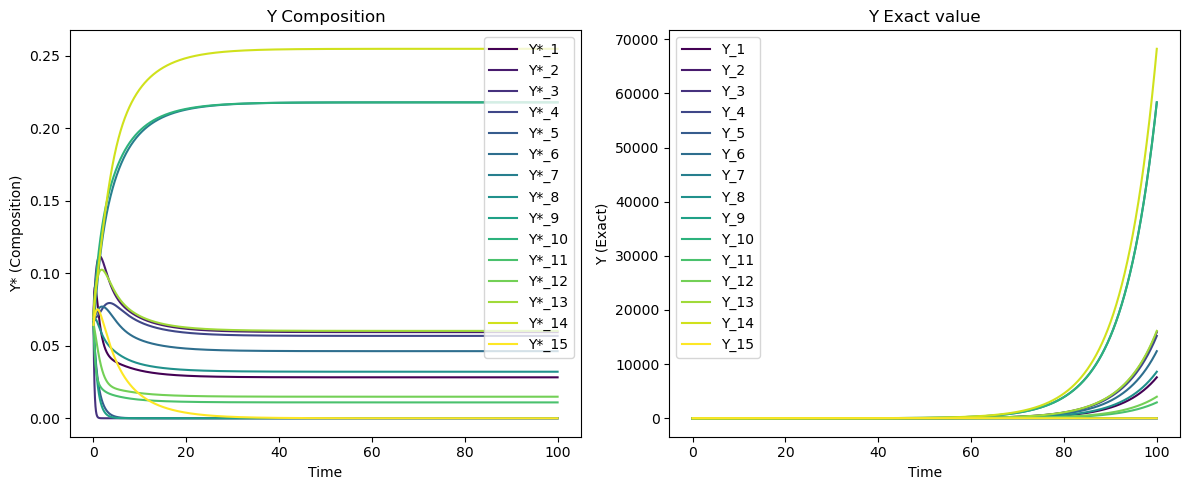

In [7]:
'''
Single network growth
'''
def main_example():
    # generate random networks
    N_X_raw, N_Y_raw, N_R_raw = 10, 15, 20
    Stot, N_X, N_Y, N_R, S_plus, S_minus = Generate_Random_Network(
        N_X_raw, N_Y_raw, N_R_raw,
        diluted=True, ambiguity=False, autonomy=True
    )
    
    # construct kinetics
    Y0, kf, kd = Construct_Kinetics(
        N_X, N_Y, N_R, S_plus, S_minus, degradation=False
    )
    print("Initial Y0:", Y0)
    print("kf:", np.round(kf, 3))
    print("kd:", kd if kd is not None else "None")


    # simulating
    dt = 1e-3
    n_steps = 100000
    t_eval, Ystar_traj, Yabs_traj, mus, N_traj = Solve_Scaled_System(
        S_minus, S_plus, Y0, N_X, N_Y, N_R,
        kf, kd, law="MA", dt=dt, n_steps=n_steps
    )

    # long-term growth rate λ
    lambda_est = compute_long_term_growth_rate(mus, last_n=100)
    print(f"Estimated long-term growth rate λ ≈ {lambda_est:.5f}\n")

    S_plus_trim = S_plus[N_X:, :]
    S_minus_trim = S_minus[N_X:, :]
    
    # mgf

    # algo1.growthRateGraph，max_steps/time_limit
    _, db_alpha, *_ = algo1.growthRateGraph(
        S_plus_trim, S_minus_trim,
        max_steps=1000, time_limit_iteration=100
    )
    
    mgf = db_alpha  

    # von-neumann growth factor
    alpha, beta, x_alpha, p_alpha, x_beta, p_beta = compute_von_neumann_alpha_beta(
    S_plus_trim, S_minus_trim)

    mu = compute_topological_growth_bound(S_minus_trim, alpha, x_alpha)

    print(f" mgf = {mgf:.5f}; Von-neumann alpha = {alpha:.5f}; Von-neumann beta = {beta:.5f}; μ = {mu:.5f};  λ = {lambda_est:.5f}")

    # plot Y* vs time, exact Y vs time -----
    plt.figure(figsize=(12, 5))
    colors = plt.cm.viridis(np.linspace(0, 1, N_Y))

    plt.subplot(1, 2, 1)
    for i in range(N_Y):
        plt.plot(t_eval, Ystar_traj[i, :], label=f"Y*_{i+1}", color=colors[i])
    plt.xlabel("Time")
    plt.ylabel("Y* (Composition)")
    plt.title("Y Composition")
    plt.legend()

    plt.subplot(1, 2, 2)
    for i in range(N_Y):
        plt.plot(t_eval, Yabs_traj[i, :], label=f"Y_{i+1}", color=colors[i])
    plt.xlabel("Time")
    plt.ylabel("Y (Exact)")
    plt.title("Y Exact value")
    plt.legend()

    plt.tight_layout()
    plt.show()

# run
if __name__ == "__main__":
    main_example()

Matrix Stot:
   1  2  3  4  5  6  7  8  9
1  0  0  0  0  0  0  0  1  0
2  0  0  0  0  0  0  0  0 -1
3  0  0  0  0  0  0  1  0  0
4 -1  1  0  0  0  0  0  0  0
5  0  1  0 -1  1 -1  0  0  0
6  0 -1 -1  0  0  0  0  1  0
7  1  0  0  1  0  1  1 -2  1
8 -1  1  1  1 -1  0 -1  1 -2
9  0 -1 -2 -1  1 -1  0  0  0

S_plus:
   1  2  3  4  5  6  7  8  9
1  0  0  0  0  0  0  0  1  0
2  0  0  0  0  0  0  0  0  0
3  0  0  0  0  0  0  1  0  0
4  0  1  0  0  0  0  0  0  0
5  0  1  0  0  1  0  0  0  0
6  0  0  0  0  0  0  0  1  0
7  1  0  0  1  0  1  1  0  1
8  0  1  1  1  0  0  0  1  0
9  0  0  0  0  1  0  0  0  0

S_minus:
   1  2  3  4  5  6  7  8  9
1  0  0  0  0  0  0  0  0  0
2  0  0  0  0  0  0  0  0  1
3  0  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0
5  0  0  0  1  0  1  0  0  0
6  0  1  1  0  0  0  0  0  0
7  0  0  0  0  0  0  0  2  0
8  1  0  0  0  1  0  1  0  2
9  0  1  2  1  0  1  0  0  0
NX = 6
NY = 3
NR = 9
【1/200】  α = 1.19149,  β = 1.19149, μ = 0.22226,  λ = -0.35210
collect 1 effe

【8/200】  α = 1.32472,  β = 1.32472, μ = 0.32472,  λ = 0.30290
collect 8 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7
1  0 -1  0  0  1 -1 -1
2  0  0  0  0  1  0  0
3  1  1  0  0  0  1  0
4 -1  2  1  0 -1 -1 -1
5  2 -1  0 -1  1  2  1
6 -1  0 -1  1  0  0  0

S_plus:
   1  2  3  4  5  6  7
1  0  0  0  0  1  0  0
2  0  0  0  0  1  0  0
3  1  1  0  0  0  1  0
4  0  2  1  0  0  0  0
5  2  0  0  0  1  2  1
6  0  0  0  1  0  0  0

S_minus:
   1  2  3  4  5  6  7
1  0  1  0  0  0  1  1
2  0  0  0  0  0  0  0
3  0  0  0  0  0  0  0
4  1  0  0  0  1  1  1
5  0  1  0  1  0  0  0
6  1  0  1  0  0  0  0
NX = 3
NY = 3
NR = 7
【9/200】  α = 2.00000,  β = 2.00000, μ = 1.00000,  λ = 0.62805
collect 9 effective (α, β, mu, λ), end
Matrix Stot:
   1   2   3   4   5   6   7   8   9   10
1   0   0   1   0   0   0   0   0   0   0
2   1   0   0   0   1   1   0  -1   1   0
3  -2   0   1   0   0   1   0   0   0   1
4   0   0  -1   0   0   0   0   0   0  -1
5   0   0   0   0   0   0   0  -1   0  

/Users/dlacoste/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


【16/200】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = 0.00029
collect 16 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8
1  0  0  0  0  0  0  0  1
2  0  0 -2  1  1 -2  0 -1
3  0  1  0  0  1  0  0  0
4  0  0  0  0 -1  0 -1  0
5  1 -1  0  1  0  0  0  1
6 -1  0 -1  0  0  0  0  1
7  2 -1  0  0 -1  0 -1  0
8  0  1  0  1  0  1  1  0
9  0  0  1 -1  1 -1 -1 -1

S_plus:
   1  2  3  4  5  6  7  8
1  0  0  0  0  0  0  0  1
2  0  0  0  1  1  0  0  0
3  0  1  0  0  1  0  0  0
4  0  0  0  0  0  0  0  0
5  1  0  0  1  0  0  0  1
6  0  0  0  0  0  0  0  1
7  2  0  0  0  0  0  0  0
8  0  1  0  1  0  1  1  0
9  0  0  1  0  1  0  0  0

S_minus:
   1  2  3  4  5  6  7  8
1  0  0  0  0  0  0  0  0
2  0  0  2  0  0  2  0  1
3  0  0  0  0  0  0  0  0
4  0  0  0  0  1  0  1  0
5  0  1  0  0  0  0  0  0
6  1  0  1  0  0  0  0  0
7  0  1  0  0  1  0  1  0
8  0  0  0  0  0  0  0  0
9  0  0  0  1  0  1  1  1
NX = 5
NY = 4
NR = 8
Matrix Stot:
   1  2  3  4  5  6  7
1 -1  0  0  0  0  0  0
2  0 

/Users/dlacoste/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


【19/200】  α = 1.41421,  β = 1.41421, μ = 0.41421,  λ = 0.00006
collect 19 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6
1  0 -2  0  0 -1  0
2 -1  0  0  0  0  0
3  0  0  1 -1  0  0
4  1  1 -1 -1  1  3
5  0 -1 -1  1  1  0
6  0  0 -1  0  1 -1
7 -1  0  1  0 -1  0

S_plus:
   1  2  3  4  5  6
1  0  0  0  0  0  0
2  0  0  0  0  0  0
3  0  0  1  0  0  0
4  1  1  0  0  1  3
5  0  0  0  1  1  0
6  0  0  0  0  1  0
7  0  0  1  0  0  0

S_minus:
   1  2  3  4  5  6
1  0  2  0  0  1  0
2  1  0  0  0  0  0
3  0  0  0  1  0  0
4  0  0  1  1  0  0
5  0  1  1  0  0  0
6  0  0  1  0  0  1
7  1  0  0  0  1  0
NX = 3
NY = 4
NR = 6
【20/200】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = 0.00011
collect 20 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5
1  0  0  0 -1 -1
2 -1 -1  0  0  0
3  0 -1  0  0  0
4  1  0  0  0  0
5  1  1 -1  1  3
6 -2  2  1  0 -1
7  1 -1  0 -1  0

S_plus:
   1  2  3  4  5
1  0  0  0  0  0
2  0  0  0  0  0
3  0  0  0  0  0
4  1  0  0  0  0
5  1  1  0  1  3
6

【28/200】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = 0.00392
collect 28 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5
1  0  1  0  0 -1
2  2  0  0  0  1
3  0 -1  0 -1  0
4  1 -1  0  0  0
5  0  0  0  1  0
6 -1 -1  1 -1 -1
7  0  1 -1  0  1
8  0  1  0  0  0

S_plus:
   1  2  3  4  5
1  0  1  0  0  0
2  2  0  0  0  1
3  0  0  0  0  0
4  1  0  0  0  0
5  0  0  0  1  0
6  0  0  1  0  0
7  0  1  0  0  1
8  0  1  0  0  0

S_minus:
   1  2  3  4  5
1  0  0  0  0  1
2  0  0  0  0  0
3  0  1  0  1  0
4  0  1  0  0  0
5  0  0  0  0  0
6  1  1  0  1  1
7  0  0  1  0  0
8  0  0  0  0  0
NX = 3
NY = 5
NR = 5
Matrix Stot:
   1  2  3  4  5  6
1  1  0  0  0 -1  0
2  0  0  0  0  2 -1
3  0  1 -1  0 -2 -1
4  1 -1  1  1  1  1
5 -1 -1  2 -2  0 -1

S_plus:
   1  2  3  4  5  6
1  1  0  0  0  0  0
2  0  0  0  0  2  0
3  0  1  0  0  0  0
4  1  0  1  1  1  1
5  0  0  2  0  0  0

S_minus:
   1  2  3  4  5  6
1  0  0  0  0  1  0
2  0  0  0  0  0  1
3  0  0  1  0  2  1
4  0  1  0  0  0  0
5  1  1  0  2

【35/200】  α = 1.87939,  β = 1.87939, μ = 0.87939,  λ = 0.43109
collect 35 effective (α, β, mu, λ), end
Matrix Stot:
    1  2  3  4  5
1  -1  1  0  0  1
2   0 -1  0  0 -1
3   0  0  1  0  0
4   0  0 -1  0  0
5   0  0 -1  0  0
6   0  0  0  0 -1
7   1  1  1 -1  0
8  -1  0  1  1  1
9  -1  0  0  1 -1
10  0 -1 -1  0  1

S_plus:
    1  2  3  4  5
1   0  1  0  0  1
2   0  0  0  0  0
3   0  0  1  0  0
4   0  0  0  0  0
5   0  0  0  0  0
6   0  0  0  0  0
7   1  1  1  0  0
8   0  0  1  1  1
9   0  0  0  1  0
10  0  0  0  0  1

S_minus:
    1  2  3  4  5
1   1  0  0  0  0
2   0  1  0  0  1
3   0  0  0  0  0
4   0  0  1  0  0
5   0  0  1  0  0
6   0  0  0  0  1
7   0  0  0  1  0
8   1  0  0  0  0
9   1  0  0  0  1
10  0  1  1  0  0
NX = 6
NY = 4
NR = 5
【36/200】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = 0.00915
collect 36 effective (α, β, mu, λ), end
Matrix Stot:
   1   2   3   4   5   6   7   8   9   10
1   0   0   1   0  -1   0   0   0   1   0
2  -1   0   0   0   0  -2  -2   1   0   0
3   0  -

【40/200】  α = 1.41421,  β = 1.41421, μ = 0.41421,  λ = 0.08629
collect 40 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8  9
1  0  0  0 -1  0  0  0  1  0
2  0  0  0  2  0  0  0  0  0
3  0  0  0  0 -1  1  0  0  0
4  0  0  0  0  0 -1  0 -2  0
5  0 -2  0  0  0  0  0  0  0
6  2  1  0  0  0 -1 -1  1  0
7 -2  2 -2  0  2  0  0 -1 -1
8  0 -1 -1 -1 -1  1  1  0  0
9  0  0  1  1  1 -1  0  1  1

S_plus:
   1  2  3  4  5  6  7  8  9
1  0  0  0  0  0  0  0  1  0
2  0  0  0  2  0  0  0  0  0
3  0  0  0  0  0  1  0  0  0
4  0  0  0  0  0  0  0  0  0
5  0  0  0  0  0  0  0  0  0
6  2  1  0  0  0  0  0  1  0
7  0  2  0  0  2  0  0  0  0
8  0  0  0  0  0  1  1  0  0
9  0  0  1  1  1  0  0  1  1

S_minus:
   1  2  3  4  5  6  7  8  9
1  0  0  0  1  0  0  0  0  0
2  0  0  0  0  0  0  0  0  0
3  0  0  0  0  1  0  0  0  0
4  0  0  0  0  0  1  0  2  0
5  0  2  0  0  0  0  0  0  0
6  0  0  0  0  0  1  1  0  0
7  2  0  2  0  0  0  0  1  1
8  0  1  1  1  1  0  0  0  0
9  0  0  0  0  0  1  0  

【46/200】  α = 1.41421,  β = 1.41421, μ = 0.41421,  λ = 0.03131
collect 46 effective (α, β, mu, λ), end
Matrix Stot:
   1   2   3   4   5   6   7   8   9   10
1   0   0   1   0   0   0   0   0   0  -1
2   0   0   0   0   1   0   0   0   0   0
3   0   0   0   0   0   0   0   0  -1   0
4   0   0  -1   1   1   0   1   0   0   0
5   0  -1  -1   0  -1   0  -1  -1  -1   1
6  -1   0   1   0   0   1   0   0   1   0
7  -1  -1   0   0   0   1   1   0  -1   0
8   1   1   0  -1   0  -2  -1   1   0   0
9   0   0   1   0   1  -1   0   0   0  -1

S_plus:
   1   2   3   4   5   6   7   8   9   10
1   0   0   1   0   0   0   0   0   0   0
2   0   0   0   0   1   0   0   0   0   0
3   0   0   0   0   0   0   0   0   0   0
4   0   0   0   1   1   0   1   0   0   0
5   0   0   0   0   0   0   0   0   0   1
6   0   0   1   0   0   1   0   0   1   0
7   0   0   0   0   0   1   1   0   0   0
8   1   1   0   0   0   0   0   1   0   0
9   0   0   1   0   1   0   0   0   0   0

S_minus:
   1   2   3   4   5   6 

【50/200】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = 0.00572
collect 50 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6
1  0  0  0  1 -1  0
2  1  0  0  0  1  0
3  0  0  0 -1  0 -1
4  0 -1 -1  0  0  0
5 -1 -1  1  0  0 -1
6  1  2  0  1 -2  1
7  1  1  0 -1  1  1
8 -1 -1 -1  0  0 -1

S_plus:
   1  2  3  4  5  6
1  0  0  0  1  0  0
2  1  0  0  0  1  0
3  0  0  0  0  0  0
4  0  0  0  0  0  0
5  0  0  1  0  0  0
6  1  2  0  1  0  1
7  1  1  0  0  1  1
8  0  0  0  0  0  0

S_minus:
   1  2  3  4  5  6
1  0  0  0  0  1  0
2  0  0  0  0  0  0
3  0  0  0  1  0  1
4  0  1  1  0  0  0
5  1  1  0  0  0  1
6  0  0  0  0  2  0
7  0  0  0  1  0  0
8  1  1  1  0  0  1
NX = 4
NY = 4
NR = 6
Matrix Stot:
   1  2  3  4  5
1 -1  0  1  1  0
2  0  0 -1  1  1
3  0  0  0  0 -1
4  1  0 -1  0  0
5 -1  3  2  0  1
6  1  0  0  1 -1
7 -1 -1  0 -1  0

S_plus:
   1  2  3  4  5
1  0  0  1  1  0
2  0  0  0  1  1
3  0  0  0  0  0
4  1  0  0  0  0
5  0  3  2  0  1
6  1  0  0  1  0
7  0  0  0  0  0

S_minus:


【56/200】  α = 2.00000,  β = 2.00000, μ = 1.00000,  λ = 0.74249
collect 56 effective (α, β, mu, λ), end
Matrix Stot:
    1  2  3  4  5  6
1  -1  1  0  0  1  0
2  -1  0  0  0  0  0
3   1  0  0  0  0 -1
4   0  0 -1  0  0  0
5   0 -1 -1  0  1  1
6   0  1  1  1  0 -1
7   1 -1  1  0 -1  0
8   0 -1  0  0  1  0
9   0  1 -1 -1  0  0
10 -1  0  0  0  0  0

S_plus:
    1  2  3  4  5  6
1   0  1  0  0  1  0
2   0  0  0  0  0  0
3   1  0  0  0  0  0
4   0  0  0  0  0  0
5   0  0  0  0  1  1
6   0  1  1  1  0  0
7   1  0  1  0  0  0
8   0  0  0  0  1  0
9   0  1  0  0  0  0
10  0  0  0  0  0  0

S_minus:
    1  2  3  4  5  6
1   1  0  0  0  0  0
2   1  0  0  0  0  0
3   0  0  0  0  0  1
4   0  0  1  0  0  0
5   0  1  1  0  0  0
6   0  0  0  0  0  1
7   0  1  0  0  1  0
8   0  1  0  0  0  0
9   0  0  1  1  0  0
10  1  0  0  0  0  0
NX = 4
NY = 6
NR = 6
Matrix Stot:
   1   2   3   4   5   6   7   8   9   10
1   0   0  -1  -2   1   0   0   1   0   0
2   0   0   1   1   1   0   0   1   0  -1
3   1   1   

【61/200】  α = 1.00000,  β = 1.00000, μ = -0.00000,  λ = 0.00000
collect 61 effective (α, β, mu, λ), end
Matrix Stot:
    1  2  3  4  5  6  7
1  -1  0  0  0 -2  0  2
2   1  0  1  0  0  0  0
3   0  1  0  0  0  0  0
4   0 -1 -2  0  0 -1  0
5   0 -1  0  0  0  0 -1
6   1  0 -1  1  1  0  0
7  -1  0  0  0 -1  0  1
8   1  1  0  1  0  0 -1
9   0  0  1 -1  1 -1  0
10  0 -1  0  0  0  2  0

S_plus:
    1  2  3  4  5  6  7
1   0  0  0  0  0  0  2
2   1  0  1  0  0  0  0
3   0  1  0  0  0  0  0
4   0  0  0  0  0  0  0
5   0  0  0  0  0  0  0
6   1  0  0  1  1  0  0
7   0  0  0  0  0  0  1
8   1  1  0  1  0  0  0
9   0  0  1  0  1  0  0
10  0  0  0  0  0  2  0

S_minus:
    1  2  3  4  5  6  7
1   1  0  0  0  2  0  0
2   0  0  0  0  0  0  0
3   0  0  0  0  0  0  0
4   0  1  2  0  0  1  0
5   0  1  0  0  0  0  1
6   0  0  1  0  0  0  0
7   1  0  0  0  1  0  0
8   0  0  0  0  0  0  1
9   0  0  0  1  0  1  0
10  0  1  0  0  0  0  0
NX = 5
NY = 5
NR = 7
【62/200】  α = 1.46557,  β = 1.46557, μ = 0.46557,  

/Users/dlacoste/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


【67/200】  α = 1.60060,  β = 1.60060, μ = 0.66501,  λ = 0.41965
collect 67 effective (α, β, mu, λ), end
Matrix Stot:
    1  2  3  4  5  6  7  8  9
1  -1  0  0  0 -1  0 -1  0  0
2  -1 -1  0  1  0  0 -1  0  0
3   0  0  0  1  0  0  0  0  0
4   1  0  0  0  0  0  0  1  0
5   0  0  0  0  0  1  0  0  0
6   0  0  0  0  1  0  0  0  0
7   0  0 -1  0  0  0 -1  1  1
8   1  0  1 -1  0  0  0 -1  0
9   0  1  0 -1 -1 -1  1  0 -1
10  0  0  0  0  1  2  0  0  0
11 -1 -2  0  1 -1 -1  0  1  0

S_plus:
    1  2  3  4  5  6  7  8  9
1   0  0  0  0  0  0  0  0  0
2   0  0  0  1  0  0  0  0  0
3   0  0  0  1  0  0  0  0  0
4   1  0  0  0  0  0  0  1  0
5   0  0  0  0  0  1  0  0  0
6   0  0  0  0  1  0  0  0  0
7   0  0  0  0  0  0  0  1  1
8   1  0  1  0  0  0  0  0  0
9   0  1  0  0  0  0  1  0  0
10  0  0  0  0  1  2  0  0  0
11  0  0  0  1  0  0  0  1  0

S_minus:
    1  2  3  4  5  6  7  8  9
1   1  0  0  0  1  0  1  0  0
2   1  1  0  0  0  0  1  0  0
3   0  0  0  0  0  0  0  0  0
4   0  0  0  0  0  0  0  

【74/200】  α = 1.22474,  β = 1.22474, μ = 0.26599,  λ = -0.00004
collect 74 effective (α, β, mu, λ), end
Matrix Stot:
    1  2  3  4  5  6  7  8
1   0  0  0  0  0  0  0 -1
2  -1  0  0  2 -1  1  0  0
3   0  0  0  0  0 -1  0  0
4   0  0  0  0  1  0  0  0
5   0  1  0 -1  0  0  0  1
6   0 -1  0  0  1  1  0  1
7   0  1  1 -1  0 -1  0  1
8  -1  0 -1  1  0  1  1  0
9   1 -1  1 -1  0 -1  0  0
10  0 -1  0  0 -1  0 -2 -1

S_plus:
    1  2  3  4  5  6  7  8
1   0  0  0  0  0  0  0  0
2   0  0  0  2  0  1  0  0
3   0  0  0  0  0  0  0  0
4   0  0  0  0  1  0  0  0
5   0  1  0  0  0  0  0  1
6   0  0  0  0  1  1  0  1
7   0  1  1  0  0  0  0  1
8   0  0  0  1  0  1  1  0
9   1  0  1  0  0  0  0  0
10  0  0  0  0  0  0  0  0

S_minus:
    1  2  3  4  5  6  7  8
1   0  0  0  0  0  0  0  1
2   1  0  0  0  1  0  0  0
3   0  0  0  0  0  1  0  0
4   0  0  0  0  0  0  0  0
5   0  0  0  1  0  0  0  0
6   0  1  0  0  0  0  0  0
7   0  0  0  1  0  1  0  0
8   1  0  1  0  0  0  0  0
9   0  1  0  1  0  1  0  0


/Users/dlacoste/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


【79/200】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = -0.00028
collect 79 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6
1  1  0  0  1  0  0
2  1  0  0  0  0  0
3 -1  0 -1 -1 -2  0
4  1  1 -1  0  0 -1
5  0  1  0  0  0  1
6  0  1  3  1  1  0
7  0 -1 -1  1  0  1

S_plus:
   1  2  3  4  5  6
1  1  0  0  1  0  0
2  1  0  0  0  0  0
3  0  0  0  0  0  0
4  1  1  0  0  0  0
5  0  1  0  0  0  1
6  0  1  3  1  1  0
7  0  0  0  1  0  1

S_minus:
   1  2  3  4  5  6
1  0  0  0  0  0  0
2  0  0  0  0  0  0
3  1  0  1  1  2  0
4  0  0  1  0  0  1
5  0  0  0  0  0  0
6  0  0  0  0  0  0
7  0  1  1  0  0  0
NX = 2
NY = 5
NR = 6
Matrix Stot:
   1  2  3  4
1  0 -1  0 -1
2  1  0  0  0
3  0 -1 -1  0
4 -1  1  1  1
5  1  1  0 -1

S_plus:
   1  2  3  4
1  0  0  0  0
2  1  0  0  0
3  0  0  0  0
4  0  1  1  1
5  1  1  0  0

S_minus:
   1  2  3  4
1  0  1  0  1
2  0  0  0  0
3  0  1  1  0
4  1  0  0  0
5  0  0  0  1
NX = 2
NY = 3
NR = 4
Matrix Stot:
   1   2   3   4   5   6   7   8   9   10
1  

【84/200】  α = 1.61803,  β = 1.61803, μ = 0.61803,  λ = 0.21007
collect 84 effective (α, β, mu, λ), end
Matrix Stot:
    1  2  3  4  5  6  7
1  -1  0  1  1  0  0 -1
2  -1  0  0  0  0 -1  0
3   0  0  0 -1  0  0  0
4   0  1  0  1  0  0  0
5   0  0  0  0 -1  0  0
6   0  1  0  1 -2 -1  0
7  -1  0  1  0  0  1  1
8   0 -1  0 -1  1  1  0
9   1  1 -1  0  0  0 -1
10  0  0 -2  0  1  1  1
11  0  0  1  0  0  0  0

S_plus:
    1  2  3  4  5  6  7
1   0  0  1  1  0  0  0
2   0  0  0  0  0  0  0
3   0  0  0  0  0  0  0
4   0  1  0  1  0  0  0
5   0  0  0  0  0  0  0
6   0  1  0  1  0  0  0
7   0  0  1  0  0  1  1
8   0  0  0  0  1  1  0
9   1  1  0  0  0  0  0
10  0  0  0  0  1  1  1
11  0  0  1  0  0  0  0

S_minus:
    1  2  3  4  5  6  7
1   1  0  0  0  0  0  1
2   1  0  0  0  0  1  0
3   0  0  0  1  0  0  0
4   0  0  0  0  0  0  0
5   0  0  0  0  1  0  0
6   0  0  0  0  2  1  0
7   1  0  0  0  0  0  0
8   0  1  0  1  0  0  0
9   0  0  1  0  0  0  1
10  0  0  2  0  0  0  0
11  0  0  0  0  0  0  0
N

【90/200】  α = 1.32472,  β = 1.32472, μ = 0.43016,  λ = 0.00205
collect 90 effective (α, β, mu, λ), end
Matrix Stot:
   1   2   3   4   5   6   7   8   9   10
1   0   0   0   0   0   1   0   0   1   0
2   1   0   0   1   0  -1   1   0   0   0
3   0   1   0  -1   0   1   1   0   1   1
4  -1   0   2   0   0  -2   1   0   0   1
5  -1   0   1   0  -1   0   0  -1   0  -1
6   2   0  -1   0   2   0   0   2  -1   0
7  -1  -1   0   2  -2   0  -1  -1   0   0

S_plus:
   1   2   3   4   5   6   7   8   9   10
1   0   0   0   0   0   1   0   0   1   0
2   1   0   0   1   0   0   1   0   0   0
3   0   1   0   0   0   1   1   0   1   1
4   0   0   2   0   0   0   1   0   0   1
5   0   0   1   0   0   0   0   0   0   0
6   2   0   0   0   2   0   0   2   0   0
7   0   0   0   2   0   0   0   0   0   0

S_minus:
   1   2   3   4   5   6   7   8   9   10
1   0   0   0   0   0   0   0   0   0   0
2   0   0   0   0   0   1   0   0   0   0
3   0   0   0   1   0   0   0   0   0   0
4   1   0   0   0   0   2

【100/200】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = 0.01032
collect 100 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5
1  1  2  0  0  0
2  0  0  0  0  1
3  0  0  0 -1  1
4 -1  0  0 -1  0
5  0 -1  1  0  0
6 -1  0  0  0  0
7 -1  1 -1  1  1
8  1 -1  1  0  0
9  0  0  0 -1 -2

S_plus:
   1  2  3  4  5
1  1  2  0  0  0
2  0  0  0  0  1
3  0  0  0  0  1
4  0  0  0  0  0
5  0  0  1  0  0
6  0  0  0  0  0
7  0  1  0  1  1
8  1  0  1  0  0
9  0  0  0  0  0

S_minus:
   1  2  3  4  5
1  0  0  0  0  0
2  0  0  0  0  0
3  0  0  0  1  0
4  1  0  0  1  0
5  0  1  0  0  0
6  1  0  0  0  0
7  1  0  1  0  0
8  0  1  0  0  0
9  0  0  0  1  2
NX = 5
NY = 4
NR = 5
Matrix Stot:
   1  2  3  4  5  6
1 -1  0  1 -1  0  0
2  0  0 -1  0 -1 -1
3  0  0  0  0 -1  0
4  0  0 -2 -1  1  1
5  1 -1  2  1 -1 -1
6 -1  1  0  0  1  2

S_plus:
   1  2  3  4  5  6
1  0  0  1  0  0  0
2  0  0  0  0  0  0
3  0  0  0  0  0  0
4  0  0  0  0  1  1
5  1  0  2  1  0  0
6  0  1  0  0  1  2

S_minus:
   1  2  3  4  5  6


/Users/dlacoste/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


【103/200】  α = 1.49453,  β = 1.49453, μ = 0.63147,  λ = 0.35584
collect 103 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7
1  0  0  0  0  1  0  0
2  0  1  2  0  0  0  0
3  0  0  0  0  0  0  1
4  1  0  0  0  0  0 -1
5  0  0 -1  0  1  0  0
6  1  0 -1 -1  1 -1  1
7  0  0  1  1  0  1  0
8  0 -1  0  1 -1  0 -2
9 -1  1  0  0  0  0  1

S_plus:
   1  2  3  4  5  6  7
1  0  0  0  0  1  0  0
2  0  1  2  0  0  0  0
3  0  0  0  0  0  0  1
4  1  0  0  0  0  0  0
5  0  0  0  0  1  0  0
6  1  0  0  0  1  0  1
7  0  0  1  1  0  1  0
8  0  0  0  1  0  0  0
9  0  1  0  0  0  0  1

S_minus:
   1  2  3  4  5  6  7
1  0  0  0  0  0  0  0
2  0  0  0  0  0  0  0
3  0  0  0  0  0  0  0
4  0  0  0  0  0  0  1
5  0  0  1  0  0  0  0
6  0  0  1  1  0  1  0
7  0  0  0  0  0  0  0
8  0  1  0  0  1  0  2
9  1  0  0  0  0  0  0
NX = 3
NY = 6
NR = 7
Matrix Stot:
   1  2  3  4  5  6  7  8  9
1  0  1  0  0  0  0  0  0  0
2 -2  0  0  0 -1  0  1  0  0
3  0  0 -1  0  0  0  0  0 -1
4  0  0  1  1  0  0  0 

【109/200】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = -0.00000
collect 109 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8  9
1  0  0  0  1  0  0  0  0  0
2 -1  0  0  0  0  0  0  0  0
3  0  0  0  0  0 -1  1  0  1
4  0  1  0  1  1  0  1 -1  0
5  0  0  1  1  1  0  0  0 -1
6  1 -1  0 -1 -1  1 -1  0 -1
7 -1  0 -1  0  1  0  1  1  0

S_plus:
   1  2  3  4  5  6  7  8  9
1  0  0  0  1  0  0  0  0  0
2  0  0  0  0  0  0  0  0  0
3  0  0  0  0  0  0  1  0  1
4  0  1  0  1  1  0  1  0  0
5  0  0  1  1  1  0  0  0  0
6  1  0  0  0  0  1  0  0  0
7  0  0  0  0  1  0  1  1  0

S_minus:
   1  2  3  4  5  6  7  8  9
1  0  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0
3  0  0  0  0  0  1  0  0  0
4  0  0  0  0  0  0  0  1  0
5  0  0  0  0  0  0  0  0  1
6  0  1  0  1  1  0  1  0  1
7  1  0  1  0  0  0  0  0  0
NX = 2
NY = 5
NR = 9
【110/200】  α = 1.61803,  β = 1.61803, μ = 0.61803,  λ = 0.00656
collect 110 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8  

/Users/dlacoste/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


【116/200】  α = 1.73205,  β = 1.73205, μ = 0.73205,  λ = 0.21400
collect 116 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7
1  0  0  0 -1 -1  2 -1
2  0 -1 -1 -1  1 -1  1
3 -1  0  0  0  0  0  0
4  0  1  0  0  0  0 -1
5  1  2  1 -1  1 -1 -1
6 -1  0 -2  0  1  0  0
7  0 -1  0  1 -1  1  2

S_plus:
   1  2  3  4  5  6  7
1  0  0  0  0  0  2  0
2  0  0  0  0  1  0  1
3  0  0  0  0  0  0  0
4  0  1  0  0  0  0  0
5  1  2  1  0  1  0  0
6  0  0  0  0  1  0  0
7  0  0  0  1  0  1  2

S_minus:
   1  2  3  4  5  6  7
1  0  0  0  1  1  0  1
2  0  1  1  1  0  1  0
3  1  0  0  0  0  0  0
4  0  0  0  0  0  0  1
5  0  0  0  1  0  1  1
6  1  0  2  0  0  0  0
7  0  1  0  0  1  0  0
NX = 4
NY = 3
NR = 7
【117/200】  α = 2.00000,  β = 2.00000, μ = 1.00000,  λ = 1.04845
collect 117 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7
1  0  0  0  0  0  0 -1
2  1 -1  0  0  0  0  0
3  0  1 -1  1  0 -1  0
4  0  0  1  0 -1  0  0
5  1 -1  1  1  1  0 -2
6 -1  0  0 -1  0  0  0
7  1  0  1 

【122/200】  α = 1.19149,  β = 1.19149, μ = 0.22226,  λ = 0.23266
collect 122 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8  9
1  0  1  0  0  0 -1  0  0 -1
2  0  0  0  0  0  0 -1  0  0
3  0  0  0  0 -1  1  0  0  0
4  1 -1 -1  0  0  1  0  0 -1
5  0  1  0  0  0 -1  0  1  0
6  1  0  1 -1  2 -1 -1  0 -1
7  1 -2 -1  0 -1  0  1 -1  0
8 -2  1 -1  3  0  1  1  1  1

S_plus:
   1  2  3  4  5  6  7  8  9
1  0  1  0  0  0  0  0  0  0
2  0  0  0  0  0  0  0  0  0
3  0  0  0  0  0  1  0  0  0
4  1  0  0  0  0  1  0  0  0
5  0  1  0  0  0  0  0  1  0
6  1  0  1  0  2  0  0  0  0
7  1  0  0  0  0  0  1  0  0
8  0  1  0  3  0  1  1  1  1

S_minus:
   1  2  3  4  5  6  7  8  9
1  0  0  0  0  0  1  0  0  1
2  0  0  0  0  0  0  1  0  0
3  0  0  0  0  1  0  0  0  0
4  0  1  1  0  0  0  0  0  1
5  0  0  0  0  0  1  0  0  0
6  0  0  0  1  0  1  1  0  1
7  0  2  1  0  1  0  0  1  0
8  2  0  1  0  0  0  0  0  0
NX = 5
NY = 3
NR = 9
【123/200】  α = 1.78377,  β = 1.78377, μ = 1.06880,  λ = 0.3

/Users/dlacoste/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


【125/200】  α = 1.52569,  β = 1.52569, μ = 0.58606,  λ = -0.07258
collect 125 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7
1 -1 -1  0  0 -1  0 -1
2  0  0  0  0 -1 -1  0
3  0  1  1  0  0 -1  0
4  0 -1  0 -1  0  1 -1
5 -1  0  1  0 -1  0  1
6 -1 -1  0  1  1  0  0
7  1  1 -1  0  1  0  0

S_plus:
   1  2  3  4  5  6  7
1  0  0  0  0  0  0  0
2  0  0  0  0  0  0  0
3  0  1  1  0  0  0  0
4  0  0  0  0  0  1  0
5  0  0  1  0  0  0  1
6  0  0  0  1  1  0  0
7  1  1  0  0  1  0  0

S_minus:
   1  2  3  4  5  6  7
1  1  1  0  0  1  0  1
2  0  0  0  0  1  1  0
3  0  0  0  0  0  1  0
4  0  1  0  1  0  0  1
5  1  0  0  0  1  0  0
6  1  1  0  0  0  0  0
7  0  0  1  0  0  0  0
NX = 2
NY = 5
NR = 7
【126/200】  α = 1.42530,  β = 1.42530, μ = 0.49225,  λ = 0.17743
collect 126 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8
1  1 -1  0  0  1  1  0  0
2  0  0  0  1  0  0 -1  1
3  0  0  0 -1  0 -1  0  0
4  1  1 -1  2  1  0  1  0
5  1  0 -1  0  0 -1  1  1
6  0  1  0 -1 -

【134/200】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = 0.00000
collect 134 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8  9
1  0  0  1  0  0  0  0  0  0
2  0 -1  0  1  0  1  0  0 -1
3  1  1 -1  0 -1  1  2  0  0
4  0  0 -2 -1  1  0  0  1 -1
5  0  0  1  1 -1 -1  0  0 -1
6  0  0  0  0  0  0  1  0  0
7  1  1  0  1  0  0 -1 -1  1
8 -1 -1  0 -1  0 -1  0  0  1

S_plus:
   1  2  3  4  5  6  7  8  9
1  0  0  1  0  0  0  0  0  0
2  0  0  0  1  0  1  0  0  0
3  1  1  0  0  0  1  2  0  0
4  0  0  0  0  1  0  0  1  0
5  0  0  1  1  0  0  0  0  0
6  0  0  0  0  0  0  1  0  0
7  1  1  0  1  0  0  0  0  1
8  0  0  0  0  0  0  0  0  1

S_minus:
   1  2  3  4  5  6  7  8  9
1  0  0  0  0  0  0  0  0  0
2  0  1  0  0  0  0  0  0  1
3  0  0  1  0  1  0  0  0  0
4  0  0  2  1  0  0  0  0  1
5  0  0  0  0  1  1  0  0  1
6  0  0  0  0  0  0  0  0  0
7  0  0  0  0  0  0  1  1  0
8  1  1  0  1  0  1  0  0  0
NX = 2
NY = 6
NR = 9
Matrix Stot:
    1  2  3  4  5  6  7  8
1  -1  0  0  0  0  

【143/200】  α = 1.41421,  β = 1.41421, μ = 0.41421,  λ = 0.00001
collect 143 effective (α, β, mu, λ), end
Matrix Stot:
    1  2  3  4  5  6  7
1   1  1  0  0  0  1  0
2   0  0 -1  0  0  0  0
3   1  0  1  1  0  0  0
4   0  0  1 -1  1  0  0
5   0  0  0  0  1  0  1
6   1  0  0 -1  0 -1  0
7   0  0 -1  1  0 -1  0
8   0 -1  0  1 -1  1  0
9  -1  0  1 -1  0  0 -1
10 -1  1 -1  0  0 -1  0

S_plus:
    1  2  3  4  5  6  7
1   1  1  0  0  0  1  0
2   0  0  0  0  0  0  0
3   1  0  1  1  0  0  0
4   0  0  1  0  1  0  0
5   0  0  0  0  1  0  1
6   1  0  0  0  0  0  0
7   0  0  0  1  0  0  0
8   0  0  0  1  0  1  0
9   0  0  1  0  0  0  0
10  0  1  0  0  0  0  0

S_minus:
    1  2  3  4  5  6  7
1   0  0  0  0  0  0  0
2   0  0  1  0  0  0  0
3   0  0  0  0  0  0  0
4   0  0  0  1  0  0  0
5   0  0  0  0  0  0  0
6   0  0  0  1  0  1  0
7   0  0  1  0  0  1  0
8   0  1  0  0  1  0  0
9   1  0  0  1  0  0  1
10  1  0  1  0  0  1  0
NX = 4
NY = 6
NR = 7
Matrix Stot:
   1  2  3  4  5  6
1  0  0  1  0  0 

【147/200】  α = 1.11179,  β = 1.11179, μ = 0.14259,  λ = 0.00016
collect 147 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7
1  0 -1  0  0  0 -1  0
2  0  0  0  1 -1  0  0
3  0  0  0 -1  1  2  0
4  0  0  0  1  0  0  1
5 -1 -1  1 -1 -1  1 -1
6 -1 -1  0  1  1 -1  1
7  1  1 -1  0 -1 -1  1

S_plus:
   1  2  3  4  5  6  7
1  0  0  0  0  0  0  0
2  0  0  0  1  0  0  0
3  0  0  0  0  1  2  0
4  0  0  0  1  0  0  1
5  0  0  1  0  0  1  0
6  0  0  0  1  1  0  1
7  1  1  0  0  0  0  1

S_minus:
   1  2  3  4  5  6  7
1  0  1  0  0  0  1  0
2  0  0  0  0  1  0  0
3  0  0  0  1  0  0  0
4  0  0  0  0  0  0  0
5  1  1  0  1  1  0  1
6  1  1  0  0  0  1  0
7  0  0  1  0  1  1  0
NX = 4
NY = 3
NR = 7
【148/200】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = -0.00001
collect 148 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8
1 -1  0 -1 -1  1 -1  0  0
2  0  1  0  0  0  0  0  0
3 -1  0  1  1  1  0  0  1
4  1  1  0 -1 -1  1  0  1
5  0  0 -1  0  1 -2  1  1
6  1 -1  1  0 -

【153/200】  α = 1.61803,  β = 1.61803, μ = 0.61803,  λ = 0.49241
collect 153 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8  9
1  0  0  1  0  0  0  0 -1  0
2  0  1  0  0 -1  0  1  0  1
3  0 -1  0  0 -1  0  0 -1  0
4  0  0  1 -1  0  0  0  0  0
5  0  0  0  0  0  0 -1  0  0
6  2  1  1 -1  1  1 -1  0  1
7  1 -1  0  0  0  0  0  0  0
8 -1 -1  0  0  0 -1  1  2 -1
9 -1  0 -1  1 -1  0 -1 -1  0

S_plus:
   1  2  3  4  5  6  7  8  9
1  0  0  1  0  0  0  0  0  0
2  0  1  0  0  0  0  1  0  1
3  0  0  0  0  0  0  0  0  0
4  0  0  1  0  0  0  0  0  0
5  0  0  0  0  0  0  0  0  0
6  2  1  1  0  1  1  0  0  1
7  1  0  0  0  0  0  0  0  0
8  0  0  0  0  0  0  1  2  0
9  0  0  0  1  0  0  0  0  0

S_minus:
   1  2  3  4  5  6  7  8  9
1  0  0  0  0  0  0  0  1  0
2  0  0  0  0  1  0  0  0  0
3  0  1  0  0  1  0  0  1  0
4  0  0  0  1  0  0  0  0  0
5  0  0  0  0  0  0  1  0  0
6  0  0  0  1  0  0  1  0  0
7  0  1  0  0  0  0  0  0  0
8  1  1  0  0  0  1  0  0  1
9  1  0  1  0  1  0  1

/Users/dlacoste/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


【155/200】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = 0.00073
collect 155 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5
1  0  0 -1 -1  0
2 -1 -1 -1  0  0
3 -1  0  0  0  0
4 -1  0  0  0  0
5  0 -1 -1  1 -1
6  1  2  1 -1  1
7  0 -1  2 -1  0
8  0  0  0  1  2

S_plus:
   1  2  3  4  5
1  0  0  0  0  0
2  0  0  0  0  0
3  0  0  0  0  0
4  0  0  0  0  0
5  0  0  0  1  0
6  1  2  1  0  1
7  0  0  2  0  0
8  0  0  0  1  2

S_minus:
   1  2  3  4  5
1  0  0  1  1  0
2  1  1  1  0  0
3  1  0  0  0  0
4  1  0  0  0  0
5  0  1  1  0  1
6  0  0  0  1  0
7  0  1  0  1  0
8  0  0  0  0  0
NX = 2
NY = 6
NR = 5
Matrix Stot:
   1   2   3   4   5   6   7   8   9   10
1   0   0   0   0   1  -2   0   1   0   1
2   0   0   1   0   0   0   1   0   0   0
3   1  -1   0   0   0   0   0   0  -1   0
4   0   1   0   0   0   0  -1   0  -1  -1
5   1  -1   1  -2  -1  -1   1   1  -1  -1
6   1  -1   0   1  -1   0   0  -1   0  -1
7   0   0   0   1   0   0  -1   1   1   0
8  -1   1  -1  -1   2   1   1   0 

【160/200】  α = 0.56520,  β = 0.56520, μ = -0.76929,  λ = -0.00005
collect 160 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8  9
1  0 -1  0  0  0  0  1  0  0
2  0  1  0  0  0 -1 -1  1  0
3  1  0  0  0 -1  0  0  0  0
4 -1  0  0  0  0  0  0  1  0
5 -1  1  0  0  0  2  0 -1  0
6  1 -1  0 -2  0  0  0  0  2
7  0  0  1  1  0 -1  0 -1 -1
8 -1  1 -2  0  2  1 -2  1  1
9  1 -1 -1  2 -1  0  1 -1  0

S_plus:
   1  2  3  4  5  6  7  8  9
1  0  0  0  0  0  0  1  0  0
2  0  1  0  0  0  0  0  1  0
3  1  0  0  0  0  0  0  0  0
4  0  0  0  0  0  0  0  1  0
5  0  1  0  0  0  2  0  0  0
6  1  0  0  0  0  0  0  0  2
7  0  0  1  1  0  0  0  0  0
8  0  1  0  0  2  1  0  1  1
9  1  0  0  2  0  0  1  0  0

S_minus:
   1  2  3  4  5  6  7  8  9
1  0  1  0  0  0  0  0  0  0
2  0  0  0  0  0  1  1  0  0
3  0  0  0  0  1  0  0  0  0
4  1  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  1  0
6  0  1  0  2  0  0  0  0  0
7  0  0  0  0  0  1  0  1  1
8  1  0  2  0  0  0  2  0  0
9  0  1  1  0  1  0 

/Users/dlacoste/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


【164/200】  α = 1.61803,  β = 1.61803, μ = 0.61803,  λ = 0.44370
collect 164 effective (α, β, mu, λ), end
Matrix Stot:
    1  2  3  4  5  6  7
1  -1  0  0  0  0  0 -1
2   0  0  1  0  0  0  0
3   0  0  0  1  0  0  0
4   0  0  1  0  0  0  0
5   0  1  1 -1  0  0 -1
6   1  0  0 -1  0  0  0
7   0  0  0  0  1 -1  0
8   0  0 -1  1  0  0  1
9  -1  0  0  1  1  1  0
10  0 -2  0  0 -2  1 -1

S_plus:
    1  2  3  4  5  6  7
1   0  0  0  0  0  0  0
2   0  0  1  0  0  0  0
3   0  0  0  1  0  0  0
4   0  0  1  0  0  0  0
5   0  1  1  0  0  0  0
6   1  0  0  0  0  0  0
7   0  0  0  0  1  0  0
8   0  0  0  1  0  0  1
9   0  0  0  1  1  1  0
10  0  0  0  0  0  1  0

S_minus:
    1  2  3  4  5  6  7
1   1  0  0  0  0  0  1
2   0  0  0  0  0  0  0
3   0  0  0  0  0  0  0
4   0  0  0  0  0  0  0
5   0  0  0  1  0  0  1
6   0  0  0  1  0  0  0
7   0  0  0  0  0  1  0
8   0  0  1  0  0  0  0
9   1  0  0  0  0  0  0
10  0  2  0  0  2  0  1
NX = 4
NY = 6
NR = 7
【165/200】  α = 1.00000,  β = 0.70711, μ = 0.00000,

/Users/dlacoste/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/dlacoste/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


【171/200】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = 0.00006
collect 171 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6
1  0  0 -1  0  0  0
2  0  0  0  0 -1 -1
3  0  0  0  0 -1  0
4  0  0 -1  0  0  0
5 -1  0  0  0  0 -1
6 -1  0  0  0 -1 -1
7  1  1 -1 -1  0  1
8 -1 -1  1  1  1  0

S_plus:
   1  2  3  4  5  6
1  0  0  0  0  0  0
2  0  0  0  0  0  0
3  0  0  0  0  0  0
4  0  0  0  0  0  0
5  0  0  0  0  0  0
6  0  0  0  0  0  0
7  1  1  0  0  0  1
8  0  0  1  1  1  0

S_minus:
   1  2  3  4  5  6
1  0  0  1  0  0  0
2  0  0  0  0  1  1
3  0  0  0  0  1  0
4  0  0  1  0  0  0
5  1  0  0  0  0  1
6  1  0  0  0  1  1
7  0  0  1  1  0  0
8  1  1  0  0  0  0
NX = 5
NY = 3
NR = 6
Matrix Stot:
    1   2   3   4   5   6   7   8   9   10
1    0   0   0  -1   1   0  -1   0   0   0
2    0   0  -1   0   0   0   0   0   0   0
3    0   0  -1   0   0   0   0   0   0   0
4    0   0   0   0  -1   0   0   1   2   0
5   -1   0   0   0   0   0   0   1  -1   0
6    0   0   0   1   0   0   0 

/Users/dlacoste/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


【178/200】  α = 0.91190,  β = 0.91190, μ = -0.14790,  λ = -0.00000
collect 178 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8  9
1  0 -2 -1  0  0 -1  0  1 -1
2  0  0  1  0  0  0 -2  1 -1
3 -1  1  0 -1 -1  1  0 -1  0
4 -1 -1  2  1  0  2  0 -1 -1
5  0  2 -1 -1  2  0 -1  0  0
6  1  0 -1  1 -1 -1  2  1  1

S_plus:
   1  2  3  4  5  6  7  8  9
1  0  0  0  0  0  0  0  1  0
2  0  0  1  0  0  0  0  1  0
3  0  1  0  0  0  1  0  0  0
4  0  0  2  1  0  2  0  0  0
5  0  2  0  0  2  0  0  0  0
6  1  0  0  1  0  0  2  1  1

S_minus:
   1  2  3  4  5  6  7  8  9
1  0  2  1  0  0  1  0  0  1
2  0  0  0  0  0  0  2  0  1
3  1  0  0  1  1  0  0  1  0
4  1  1  0  0  0  0  0  1  1
5  0  0  1  1  0  0  1  0  0
6  0  0  1  0  1  1  0  0  0
NX = 3
NY = 3
NR = 9
【179/200】  α = 2.00000,  β = 2.00000, μ = 1.00000,  λ = 1.59727
collect 179 effective (α, β, mu, λ), end
Matrix Stot:
    1  2  3  4  5  6  7  8
1   0  0  1  0  0  0  0  0
2   0  0  0  0  0 -1  0  0
3   0 -1 -1 -1  0  1  0  0
4   0

【187/200】  α = 1.52138,  β = 1.52138, μ = 0.72816,  λ = 0.22268
collect 187 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7
1  0  0  0  0  0 -1 -1
2  0  0 -1  2  0  0  0
3  1  0 -1  0  0 -1  0
4  0  0  0 -1  0  1  0
5  0  1  0  0 -1  0  0
6 -2  2 -1  1 -1  0  1
7  1  0  1 -1 -1  1  0
8  0 -1  0  0  1 -1 -1

S_plus:
   1  2  3  4  5  6  7
1  0  0  0  0  0  0  0
2  0  0  0  2  0  0  0
3  1  0  0  0  0  0  0
4  0  0  0  0  0  1  0
5  0  1  0  0  0  0  0
6  0  2  0  1  0  0  1
7  1  0  1  0  0  1  0
8  0  0  0  0  1  0  0

S_minus:
   1  2  3  4  5  6  7
1  0  0  0  0  0  1  1
2  0  0  1  0  0  0  0
3  0  0  1  0  0  1  0
4  0  0  0  1  0  0  0
5  0  0  0  0  1  0  0
6  2  0  1  0  1  0  0
7  0  0  0  1  1  0  0
8  0  1  0  0  0  1  1
NX = 5
NY = 3
NR = 7
【188/200】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = -0.27849
collect 188 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8
1  0  0  0  0  0  0  0 -1
2  0  0  1  0  0  0  0  0
3  1  1  0  0  0 -1  0  

【192/200】  α = 1.11491,  β = 1.11491, μ = 0.18869,  λ = -0.00000
collect 192 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6
1  0  0  0  0  1  0
2  0  0  0  1  1 -1
3  0  0  0  0  0  1
4  0  0 -2 -1  1  1
5  1 -1  0  2 -1 -1
6 -1  1  1 -1  0  0

S_plus:
   1  2  3  4  5  6
1  0  0  0  0  1  0
2  0  0  0  1  1  0
3  0  0  0  0  0  1
4  0  0  0  0  1  1
5  1  0  0  2  0  0
6  0  1  1  0  0  0

S_minus:
   1  2  3  4  5  6
1  0  0  0  0  0  0
2  0  0  0  0  0  1
3  0  0  0  0  0  0
4  0  0  2  1  0  0
5  0  1  0  0  1  1
6  1  0  0  1  0  0
NX = 3
NY = 3
NR = 6
【193/200】  α = 1.00000,  β = 1.00000, μ = -0.00000,  λ = -0.12319
collect 193 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6
1  0  0  0  1  0  0
2  0  1 -1  0  0  0
3 -2  0  2  1  0  1
4  0  1 -2 -1  0 -1
5  0  1  0  0 -2  0
6  1 -1  0 -1 -1  0
7  0 -2  0 -1  1  0

S_plus:
   1  2  3  4  5  6
1  0  0  0  1  0  0
2  0  1  0  0  0  0
3  0  0  2  1  0  1
4  0  1  0  0  0  0
5  0  1  0  0  0  0
6  1  0  0  

【198/200】  α = 1.00000,  β = 1.00000, μ = -0.00000,  λ = 0.00000
collect 198 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8
1  0  0  0 -1 -2  0  0  1
2  0  0  0  0  0  0  1  0
3  0  0  1  2  0  1  0 -1
4  0  1 -1  0  0  0  0  1
5 -1  0 -1  1  0 -1 -1  1
6  1  0  2 -1 -1  2  0 -1
7  0 -2  0  0  1  0  1 -1

S_plus:
   1  2  3  4  5  6  7  8
1  0  0  0  0  0  0  0  1
2  0  0  0  0  0  0  1  0
3  0  0  1  2  0  1  0  0
4  0  1  0  0  0  0  0  1
5  0  0  0  1  0  0  0  1
6  1  0  2  0  0  2  0  0
7  0  0  0  0  1  0  1  0

S_minus:
   1  2  3  4  5  6  7  8
1  0  0  0  1  2  0  0  0
2  0  0  0  0  0  0  0  0
3  0  0  0  0  0  0  0  1
4  0  0  1  0  0  0  0  0
5  1  0  1  0  0  1  1  0
6  0  0  0  1  1  0  0  1
7  0  2  0  0  0  0  0  1
NX = 3
NY = 4
NR = 8
【199/200】  α = 1.41421,  β = 1.41421, μ = 0.41421,  λ = -0.00006
collect 199 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8  9
1  0  0  0  0  0 -1  0  1  0
2  1 -1  0 -1  1  0  0 -1  0
3  0  0  0 

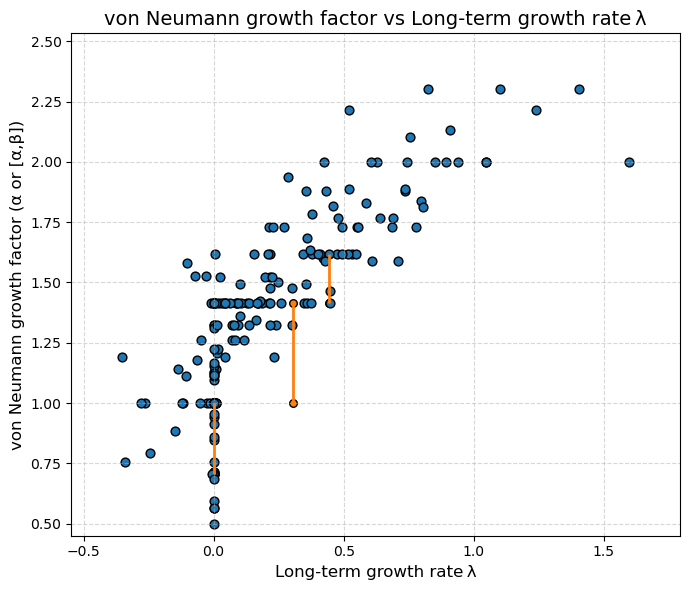

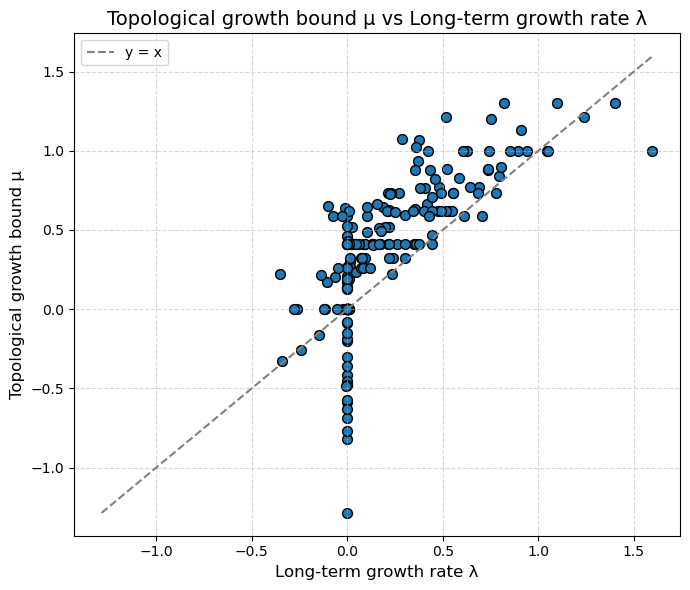

In [8]:
'''
Stoichometric autocatalytic and dynamic growth

Systems for chemical reaction order = 2
'''

def main_example():

    target_num = 200
    
    # storage
    alpha_list = []
    beta_list = []
    lambda_list = []
    mu_list = []
    
    attempts = 0       
    successes = 0       
    
    # number of trail
    while successes < target_num and attempts < 2500:
        attempts += 1
        
        # Random networks
        Stot, N_X, N_Y, N_R, S_plus, S_minus = Generate_Random_Network(
        N_X_raw=random.randint(3, 6),
        N_Y_raw=random.randint(3, 6),
        N_R_raw=random.randint(5, 10),
            diluted=False, ambiguity=False, autonomy=True
        )
        
        # Check autonomy condition
        S_plus_trim = S_plus[N_X:, :]
        S_minus_trim = S_minus[N_X:, :]
        _, _, auto = aux.checkAutonomy(S_minus_trim, S_plus_trim)
        if not auto:
            continue
        
        # von Neumann growth factor α, β
        try:
            alpha, beta, x_alpha, p_alpha, x_beta, p_beta = compute_von_neumann_alpha_beta(S_plus_trim, S_minus_trim)
        except Exception:
            continue
        if np.isnan(alpha) or np.isnan(beta):
            continue
        
        # Kinetics
        Y0, kf, kd = Construct_Kinetics(
            N_X, N_Y, N_R, S_plus, S_minus, degradation=False
        )
        
        # Simulation
        dt = 1e-3
        n_steps = 250000
        t_eval, Ystar_traj, Yabs_traj, mus, N_traj = Solve_Scaled_System(
            S_minus, S_plus, Y0, N_X, N_Y, N_R,
            kf, kd, law="MA", dt=dt, n_steps=n_steps
        )
        
        # long-term growth rate λ
        lambda_est = compute_long_term_growth_rate(mus, last_n=100)

        mu = compute_topological_growth_bound(S_minus_trim, alpha, x_alpha)
        
        # save
        alpha_list.append(alpha)
        beta_list.append(beta)
        lambda_list.append(lambda_est)
        mu_list.append(mu)
        successes += 1
        
        print(f"【{successes}/{target_num}】  α = {alpha:.5f},  β = {beta:.5f}, μ = {mu:.5f},  λ = {lambda_est:.5f}")
    
    # check loop

        print(f"collect {successes} effective (α, β, mu, λ), end")

    plt.figure(figsize=(7, 6))
    
    y_lo = []
    y_hi = []
    for a, b in zip(alpha_list, beta_list):
        y_lo.append(min(a, b))
        y_hi.append(max(a, b))
    
    λ_arr = np.array(lambda_list)
    y_lo_arr = np.array(y_lo)
    y_hi_arr = np.array(y_hi)
    
    λ_min = λ_arr.min()
    λ_max = λ_arr.max()
    
    λ_range = λ_max - λ_min
    x_min = λ_min - 0.1 * λ_range
    x_max = λ_max + 0.1 * λ_range
    
    y_min = y_lo_arr.min() * 0.9
    y_max = y_hi_arr.max() * 1.1
    
    for a, b, lam in zip(alpha_list, beta_list, lambda_list):
        if abs(a - b) < 1e-6:
            plt.scatter(lam, a, color='C0', edgecolors='k', s=40)
        else:
            lo = min(a, b)
            hi = max(a, b)
            plt.vlines(x=lam, ymin=lo, ymax=hi, color='C1', linewidth=2)
            plt.scatter([lam, lam], [lo, hi], color='C1', edgecolors='k', s=30)
    
    plt.xlabel("Long-term growth rate λ", fontsize=12)
    plt.ylabel("von Neumann growth factor (α or [α,β])", fontsize=12)
    plt.title("von Neumann growth factor vs Long-term growth rate λ", fontsize=14)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    plt.grid(linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # μ vs λ 
    plt.figure(figsize=(7, 6))
    plt.scatter(lambda_list, mu_list, marker='o', edgecolors='k', s=50)

    # reference line x = y
    all_vals = np.concatenate([lambda_list, mu_list])
    vmin, vmax = all_vals.min(), all_vals.max()
    plt.plot([vmin, vmax], [vmin, vmax], ls='--', color='gray', label='y = x')

    plt.xlabel("Long-term growth rate λ", fontsize=12)
    plt.ylabel("Topological growth bound μ", fontsize=12)
    plt.title("Topological growth bound μ vs Long-term growth rate λ", fontsize=14)
    plt.legend()
    plt.grid(linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()
    
if __name__ == "__main__":
   main_example()



Matrix Stot:
   1  2  3  4  5  6  7  8  9
1  0 -1 -1  0  0  0  0  0  0
2  0  0  0  1  1  0 -1  1 -1
3  0  0  1  0  0  0  0  0  0
4  0  0  0  0 -1  0  0  0  0
5  0 -2  0  1  2  0  1  1  2
6  1  2  1 -1 -1 -1  0 -1  0
7 -2  0 -1 -2 -1  1 -1  0 -1

S_plus:
   1  2  3  4  5  6  7  8  9
1  0  0  0  0  0  0  0  0  0
2  0  0  0  1  1  0  0  1  0
3  0  0  1  0  0  0  0  0  0
4  0  0  0  0  0  0  0  0  0
5  0  0  0  1  2  0  1  1  2
6  1  2  1  0  0  0  0  0  0
7  0  0  0  0  0  1  0  0  0

S_minus:
   1  2  3  4  5  6  7  8  9
1  0  1  1  0  0  0  0  0  0
2  0  0  0  0  0  0  1  0  1
3  0  0  0  0  0  0  0  0  0
4  0  0  0  0  1  0  0  0  0
5  0  2  0  0  0  0  0  0  0
6  0  0  0  1  1  1  0  1  0
7  2  0  1  2  1  0  1  0  1
NX = 4
NY = 3
NR = 9
【1/200】  α = 1.25992,  β = 1.25992, μ = 0.32748,  λ = 0.07095
collect 1 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8  9
1  0  2  0 -2 -1 -1  0  0  0
2  0  0  0  0  0  0  1  0 -1
3  0  0 -1  0 -1  1  1  0  0
4  0  0  0  0  1  0  

【9/200】  α = 1.29415,  β = 1.29415, μ = 0.37306,  λ = 0.15505
collect 9 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5
1  0  0  0  0 -1
2  0  1  0  0  0
3 -1 -1  0 -1  0
4 -1  0  0  0  1
5  1  0 -1  0 -1
6  0  1  1 -1  0
7 -1  0  2  2  0
8  0 -1  0  1  1

S_plus:
   1  2  3  4  5
1  0  0  0  0  0
2  0  1  0  0  0
3  0  0  0  0  0
4  0  0  0  0  1
5  1  0  0  0  0
6  0  1  1  0  0
7  0  0  2  2  0
8  0  0  0  1  1

S_minus:
   1  2  3  4  5
1  0  0  0  0  1
2  0  0  0  0  0
3  1  1  0  1  0
4  1  0  0  0  0
5  0  0  1  0  1
6  0  0  0  1  0
7  1  0  0  0  0
8  0  1  0  0  0
NX = 3
NY = 5
NR = 5
【10/200】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = 0.00979
collect 10 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7
1  0  0  0  0 -1  0  0
2  0  1  0  0  0  0 -2
3  0  0  0  0  0 -1  0
4 -2 -1 -1 -1  2  2  1
5  0 -1 -1  1  0  0 -1
6  2  1  2  0 -2 -1  0

S_plus:
   1  2  3  4  5  6  7
1  0  0  0  0  0  0  0
2  0  1  0  0  0  0  0
3  0  0  0  0  0  0  0
4  0  0  

/Users/dlacoste/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


【11/200】  α = 1.41421,  β = 1.41421, μ = 0.58579,  λ = 0.14428
collect 11 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8  9
1  1  0  0  0  0  1  0  0  0
2  0 -1  0  0  0 -1  0  0  0
3  0  0  0  0  0  1  0  1  0
4  1  0  2  0  0  0  0  0  0
5  0  1 -1  0  0  0  0  0  1
6  1 -1  1  1  0 -1  0  0  1
7  0  0  0 -1 -1  1 -1  0  0
8  0  2 -1  0  1 -1  1  1 -1
9 -1  0  0 -1  0  0  1 -1  0

S_plus:
   1  2  3  4  5  6  7  8  9
1  1  0  0  0  0  1  0  0  0
2  0  0  0  0  0  0  0  0  0
3  0  0  0  0  0  1  0  1  0
4  1  0  2  0  0  0  0  0  0
5  0  1  0  0  0  0  0  0  1
6  1  0  1  1  0  0  0  0  1
7  0  0  0  0  0  1  0  0  0
8  0  2  0  0  1  0  1  1  0
9  0  0  0  0  0  0  1  0  0

S_minus:
   1  2  3  4  5  6  7  8  9
1  0  0  0  0  0  0  0  0  0
2  0  1  0  0  0  1  0  0  0
3  0  0  0  0  0  0  0  0  0
4  0  0  0  0  0  0  0  0  0
5  0  0  1  0  0  0  0  0  0
6  0  1  0  0  0  1  0  0  0
7  0  0  0  1  1  0  1  0  0
8  0  0  1  0  0  1  0  0  1
9  1  0  0  1  0  0  0  

【18/200】  α = 1.00000,  β = 1.00000, μ = -0.00000,  λ = 0.00000
collect 18 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8
1  1  2  0  0  1 -1 -1 -1
2  0 -1  0  2  0  0  2  0
3  0  0  0  0  0 -1  0  0
4  0  0  0  0  0  0 -1  0
5  2 -1  1 -3 -1  0 -1  1
6 -1  1 -1  0  1  1  1 -1
7  0  0  0  1  1 -1  0  0

S_plus:
   1  2  3  4  5  6  7  8
1  1  2  0  0  1  0  0  0
2  0  0  0  2  0  0  2  0
3  0  0  0  0  0  0  0  0
4  0  0  0  0  0  0  0  0
5  2  0  1  0  0  0  0  1
6  0  1  0  0  1  1  1  0
7  0  0  0  1  1  0  0  0

S_minus:
   1  2  3  4  5  6  7  8
1  0  0  0  0  0  1  1  1
2  0  1  0  0  0  0  0  0
3  0  0  0  0  0  1  0  0
4  0  0  0  0  0  0  1  0
5  0  1  0  3  1  0  1  0
6  1  0  1  0  0  0  0  1
7  0  0  0  0  0  1  0  0
NX = 4
NY = 3
NR = 8
【19/200】  α = 1.76929,  β = 1.76929, μ = 0.76929,  λ = 0.45744
collect 19 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8
1  0 -1 -1  0  1 -2  1  0
2  0  0  0  0 -1  0  0  0
3  0  0  0  0  0  1 -1  0

【24/200】  α = 1.00000,  β = 1.00000, μ = -0.00000,  λ = -0.18159
collect 24 effective (α, β, mu, λ), end
Matrix Stot:
    1   2   3   4   5   6   7   8   9   10
1    0   0   0   0  -1   0  -1   0   0   0
2   -1   0   1   0   0   0   0   0   0   1
3    0   1   0   0  -1   1  -1  -1   0   0
4    0   0   1   0   0   0   1   0  -1   0
5    0   1   0   0   0   0   0   0   0   0
6   -1   0   0   0   0  -1   0   0   0   0
7    0   0   0   1   0   1   0   1   0   0
8    1   0   1   0  -1   1   1   0   2   1
9    0   1   0   0   1   0  -1  -1   0  -1
10   0  -1  -1  -1   0   0   0  -1  -1   0

S_plus:
    1   2   3   4   5   6   7   8   9   10
1    0   0   0   0   0   0   0   0   0   0
2    0   0   1   0   0   0   0   0   0   1
3    0   1   0   0   0   1   0   0   0   0
4    0   0   1   0   0   0   1   0   0   0
5    0   1   0   0   0   0   0   0   0   0
6    0   0   0   0   0   0   0   0   0   0
7    0   0   0   1   0   1   0   1   0   0
8    1   0   1   0   0   1   1   0   2   1
9    0   1   

【30/200】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = -0.03394
collect 30 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7
1  0 -1  1  1  0  0  0
2 -1  0  0  0  0  0 -2
3  1 -1  0  0  0  0  0
4 -1  2  1  2  1 -1 -1
5  1  0 -2 -2 -1  1  1
6  0 -1  0  0  0  0  1

S_plus:
   1  2  3  4  5  6  7
1  0  0  1  1  0  0  0
2  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0
4  0  2  1  2  1  0  0
5  1  0  0  0  0  1  1
6  0  0  0  0  0  0  1

S_minus:
   1  2  3  4  5  6  7
1  0  1  0  0  0  0  0
2  1  0  0  0  0  0  2
3  0  1  0  0  0  0  0
4  1  0  0  0  0  1  1
5  0  0  2  2  1  0  0
6  0  1  0  0  0  0  0
NX = 3
NY = 3
NR = 7
【31/200】  α = 1.73205,  β = 1.73205, μ = 0.84530,  λ = 0.43793
collect 31 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8  9
1  0  0  0  1  1  1  1  0  0
2 -1  0  0  0  0  0  1  0 -1
3  0  0  0  0  0  0  0 -2  0
4  0 -1  1  0 -1  0 -1  0  0
5  2  0  0 -1 -2 -1  0 -1 -2
6 -1  0 -1 -2  1  1  0  0  0
7  0  1  0  2  1  0  1  1  1
8 -1  1 -1  

【37/200】  α = 1.23718,  β = 1.23718, μ = 0.36863,  λ = 0.00001
collect 37 effective (α, β, mu, λ), end
Matrix Stot:
    1   2   3   4   5   6   7   8   9   10
1    0   0   0   0  -1   0   0   0   0   0
2    0   0   0   0   0   0   0   0   1   0
3    0   0   0   0   0   0   0  -1   0   0
4    1   0   0   1  -1   0   1   0   0   0
5    0   0  -1   0   0   0   0   0   0   0
6    0   0   0   0   0   0   0  -1  -1  -1
7    0   1   0   0  -1   0   0   1  -1  -1
8    0   0   0   1   0  -1   0   0   0   0
9    1   0   0  -1   0   0   0   0   0  -1
10   0  -1   1   0   1   0  -1  -1   1   1
11  -1   0  -1   0   0   0   0   1   0   0
12   0   0  -1   0   0   1   1   0   0   1

S_plus:
    1   2   3   4   5   6   7   8   9   10
1    0   0   0   0   0   0   0   0   0   0
2    0   0   0   0   0   0   0   0   1   0
3    0   0   0   0   0   0   0   0   0   0
4    1   0   0   1   0   0   1   0   0   0
5    0   0   0   0   0   0   0   0   0   0
6    0   0   0   0   0   0   0   0   0   0
7    0   1   0 

/Users/dlacoste/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


【41/200】  α = 1.68399,  β = 1.68399, μ = 0.79266,  λ = 0.06625
collect 41 effective (α, β, mu, λ), end
Matrix Stot:
    1  2  3  4  5  6  7  8  9
1   0  0  1  0  0  0  0  0  0
2   0  1  0  0  0  0  0  0 -1
3   0  0  0  1  0  0  0  0  0
4   0  0  0 -1  0  1  0  0  0
5   0  0  0  0  0  0  0  0  1
6   0  0  0  0  0  0 -1  0 -1
7   0  1 -1  1 -1 -1  0 -1  0
8   0 -1  1  0  0  0  0  1 -1
9   1  0  0  0  1 -1  0  0  0
10  0  0  1  1 -1  0  1  0  0
11 -1  0  0 -1  0  1  1  1  1

S_plus:
    1  2  3  4  5  6  7  8  9
1   0  0  1  0  0  0  0  0  0
2   0  1  0  0  0  0  0  0  0
3   0  0  0  1  0  0  0  0  0
4   0  0  0  0  0  1  0  0  0
5   0  0  0  0  0  0  0  0  1
6   0  0  0  0  0  0  0  0  0
7   0  1  0  1  0  0  0  0  0
8   0  0  1  0  0  0  0  1  0
9   1  0  0  0  1  0  0  0  0
10  0  0  1  1  0  0  1  0  0
11  0  0  0  0  0  1  1  1  1

S_minus:
    1  2  3  4  5  6  7  8  9
1   0  0  0  0  0  0  0  0  0
2   0  0  0  0  0  0  0  0  1
3   0  0  0  0  0  0  0  0  0
4   0  0  0  1  0  0  0  

【44/200】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = -0.28030
collect 44 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6
1  0  0  0  0 -1  0
2  0  0 -1  0 -1 -1
3  0  0  0 -1  0  1
4  0  0  1  0 -1  1
5 -1  1 -2  1  1 -1
6  0  1  0  0  0  0
7  1  1  0  1  0  0
8  0 -2  0 -2  0  0

S_plus:
   1  2  3  4  5  6
1  0  0  0  0  0  0
2  0  0  0  0  0  0
3  0  0  0  0  0  1
4  0  0  1  0  0  1
5  0  1  0  1  1  0
6  0  1  0  0  0  0
7  1  1  0  1  0  0
8  0  0  0  0  0  0

S_minus:
   1  2  3  4  5  6
1  0  0  0  0  1  0
2  0  0  1  0  1  1
3  0  0  0  1  0  0
4  0  0  0  0  1  0
5  1  0  2  0  0  1
6  0  0  0  0  0  0
7  0  0  0  0  0  0
8  0  2  0  2  0  0
NX = 3
NY = 5
NR = 6
Matrix Stot:
   1  2  3  4  5  6  7  8
1  0  0 -1  1  0  0  0  0
2  0  0  0  0  0  0  0 -1
3  1  0  0  0  0  1  0  0
4  0  0  0  0  0  0  1  0
5  1  1 -1  0 -1  1 -1  0
6 -1  1  0  0 -1 -1 -1 -1
7  0  0  0  1  2  0 -1  1
8 -1 -1  1 -1  1  1  1 -1

S_plus:
   1  2  3  4  5  6  7  8
1  0  0  0  1  0  0  

/Users/dlacoste/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


【50/200】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = 0.00000
collect 50 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8  9
1  0  0  0 -1  0  0  0  1  0
2  0  0  0  0  1 -1  0  0  0
3  0  0  0  0  0  1 -1  0  0
4  0  0 -1  0  0  0  0  0 -1
5  0  0  0  0  0  0 -1  0  0
6 -1  0  1  0  0  0  0  0  1
7 -1 -2 -2  1  1 -1  1  1 -1
8  0  2  1 -1 -1  0 -1 -1  1
9  1 -1  0  0  0  1  0  0  0

S_plus:
   1  2  3  4  5  6  7  8  9
1  0  0  0  0  0  0  0  1  0
2  0  0  0  0  1  0  0  0  0
3  0  0  0  0  0  1  0  0  0
4  0  0  0  0  0  0  0  0  0
5  0  0  0  0  0  0  0  0  0
6  0  0  1  0  0  0  0  0  1
7  0  0  0  1  1  0  1  1  0
8  0  2  1  0  0  0  0  0  1
9  1  0  0  0  0  1  0  0  0

S_minus:
   1  2  3  4  5  6  7  8  9
1  0  0  0  1  0  0  0  0  0
2  0  0  0  0  0  1  0  0  0
3  0  0  0  0  0  0  1  0  0
4  0  0  1  0  0  0  0  0  1
5  0  0  0  0  0  0  1  0  0
6  1  0  0  0  0  0  0  0  0
7  1  2  2  0  0  1  0  0  1
8  0  0  0  1  1  0  1  1  0
9  0  1  0  0  0  0  0  

【56/200】  α = 1.20557,  β = 1.20557, μ = 0.24783,  λ = 0.00007
collect 56 effective (α, β, mu, λ), end
Matrix Stot:
    1  2  3  4  5
1   0 -1  0  0  0
2   0 -1  1  0  0
3   0  1  0 -1  0
4  -1  0  0  0 -1
5  -1  0  0  0  1
6   1  0  0 -1  0
7   0 -1  0  1 -1
8   0  2  0 -1 -1
9  -1  0 -2  1  0
10  0  0  1  0  1

S_plus:
    1  2  3  4  5
1   0  0  0  0  0
2   0  0  1  0  0
3   0  1  0  0  0
4   0  0  0  0  0
5   0  0  0  0  1
6   1  0  0  0  0
7   0  0  0  1  0
8   0  2  0  0  0
9   0  0  0  1  0
10  0  0  1  0  1

S_minus:
    1  2  3  4  5
1   0  1  0  0  0
2   0  1  0  0  0
3   0  0  0  1  0
4   1  0  0  0  1
5   1  0  0  0  0
6   0  0  0  1  0
7   0  1  0  0  1
8   0  0  0  1  1
9   1  0  2  0  0
10  0  0  0  0  0
NX = 5
NY = 5
NR = 5
Matrix Stot:
   1  2  3  4  5
1  1  0  0  0 -1
2  0  0  0  0 -1
3  1  0  0  0  0
4  0  1  1  1  2
5  0  1  0  0  0
6  1 -2  1  1 -1
7 -1  1 -2 -1  1

S_plus:
   1  2  3  4  5
1  1  0  0  0  0
2  0  0  0  0  0
3  1  0  0  0  0
4  0  1  1  1  2
5  0  1

【63/200】  α = 1.41421,  β = 1.00000, μ = 0.58579,  λ = -0.00775
collect 63 effective (α, β, mu, λ), end
Matrix Stot:
   1   2   3   4   5   6   7   8   9   10
1   0   0   0   0   1   0  -1   0   0   0
2   0   0   0  -1   0   0   0   0   0   0
3   0   0   0   0   0   0   0   1   0   0
4   0   0   0  -1   0   1   0   1   0   0
5   0   0   0   0   0  -1   0   0   0   0
6   1   1   0  -1   0   2   1   0   1  -1
7  -2  -1  -1   1  -1  -2  -1  -1  -3   1
8   0   0   1   1   1   0   1   1   1   0

S_plus:
   1   2   3   4   5   6   7   8   9   10
1   0   0   0   0   1   0   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0
3   0   0   0   0   0   0   0   1   0   0
4   0   0   0   0   0   1   0   1   0   0
5   0   0   0   0   0   0   0   0   0   0
6   1   1   0   0   0   2   1   0   1   0
7   0   0   0   1   0   0   0   0   0   1
8   0   0   1   1   1   0   1   1   1   0

S_minus:
   1   2   3   4   5   6   7   8   9   10
1   0   0   0   0   0   0   1   0   0   0
2   0   0   0   1   0   

/Users/dlacoste/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


【66/200】  α = 1.41421,  β = 1.41421, μ = 0.50000,  λ = 0.39510
collect 66 effective (α, β, mu, λ), end
Matrix Stot:
    1  2  3  4  5  6
1   0  0 -1  0  1  0
2   0  0  1  1  1  0
3   0 -1  0  0  0  1
4  -2  0  0  0  0 -1
5   1  1  0  0  0  0
6  -1  1  0 -1  0  0
7   0 -1  0 -1 -1  1
8   1  0 -1  0  1 -1
9   0  0  1  1  0  0
10  0  1  1  0 -1  0

S_plus:
    1  2  3  4  5  6
1   0  0  0  0  1  0
2   0  0  1  1  1  0
3   0  0  0  0  0  1
4   0  0  0  0  0  0
5   1  1  0  0  0  0
6   0  1  0  0  0  0
7   0  0  0  0  0  1
8   1  0  0  0  1  0
9   0  0  1  1  0  0
10  0  1  1  0  0  0

S_minus:
    1  2  3  4  5  6
1   0  0  1  0  0  0
2   0  0  0  0  0  0
3   0  1  0  0  0  0
4   2  0  0  0  0  1
5   0  0  0  0  0  0
6   1  0  0  1  0  0
7   0  1  0  1  1  0
8   0  0  1  0  0  1
9   0  0  0  0  0  0
10  0  0  0  0  1  0
NX = 5
NY = 5
NR = 6
Matrix Stot:
   1  2  3  4  5  6
1  0 -1  0  0  1  0
2  0  0  0 -1  0  0
3  0  1  2  1  1  0
4 -1  1 -1 -2  1  0
5  0  0  0  0 -1 -1
6  2  0  1  0  0  

【71/200】  α = 1.41421,  β = 1.41421, μ = 0.41421,  λ = 0.22246
collect 71 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8  9
1  1  0  0  0  0  0  0 -1  0
2  0  0  0  1 -1  0  0 -1  0
3 -1  0 -1 -1  0  1  0  0  0
4  1  0 -1  0  0  0 -1  1  0
5 -1  1  0 -1  0  0  0  1  1
6 -1 -2 -1  1  2 -1 -1  0 -1
7  1 -1  1  1 -1  2 -1  1  0
8  0  0  0  0 -1  0  2 -1  1

S_plus:
   1  2  3  4  5  6  7  8  9
1  1  0  0  0  0  0  0  0  0
2  0  0  0  1  0  0  0  0  0
3  0  0  0  0  0  1  0  0  0
4  1  0  0  0  0  0  0  1  0
5  0  1  0  0  0  0  0  1  1
6  0  0  0  1  2  0  0  0  0
7  1  0  1  1  0  2  0  1  0
8  0  0  0  0  0  0  2  0  1

S_minus:
   1  2  3  4  5  6  7  8  9
1  0  0  0  0  0  0  0  1  0
2  0  0  0  0  1  0  0  1  0
3  1  0  1  1  0  0  0  0  0
4  0  0  1  0  0  0  1  0  0
5  1  0  0  1  0  0  0  0  0
6  1  2  1  0  0  1  1  0  1
7  0  1  0  0  1  0  1  0  0
8  0  0  0  0  1  0  0  1  0
NX = 4
NY = 4
NR = 9
【72/200】  α = 1.64979,  β = 1.64979, μ = 0.78773,  λ = 0.1659

/Users/dlacoste/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


【73/200】  α = 1.32472,  β = 1.32472, μ = 0.36299,  λ = 0.00000
collect 73 effective (α, β, mu, λ), end
Matrix Stot:
    1  2  3  4  5
1   1 -1  1  0 -1
2   0 -1 -2  0  0
3   0  1  0  1  0
4   0  0  0  0  1
5   1 -1  1  0 -1
6  -1  0  1 -1  0
7   1  1  0  0 -1
8   0  0 -1  0  0
9  -1  1  0  0  0
10 -1  0  0  1  1

S_plus:
    1  2  3  4  5
1   1  0  1  0  0
2   0  0  0  0  0
3   0  1  0  1  0
4   0  0  0  0  1
5   1  0  1  0  0
6   0  0  1  0  0
7   1  1  0  0  0
8   0  0  0  0  0
9   0  1  0  0  0
10  0  0  0  1  1

S_minus:
    1  2  3  4  5
1   0  1  0  0  1
2   0  1  2  0  0
3   0  0  0  0  0
4   0  0  0  0  0
5   0  1  0  0  1
6   1  0  0  1  0
7   0  0  0  0  1
8   0  0  1  0  0
9   1  0  0  0  0
10  1  0  0  0  0
NX = 4
NY = 6
NR = 5
Matrix Stot:
   1  2  3  4  5  6  7
1  0  0  0  0  1  0  1
2 -1  0 -1  0  0  1  0
3  0  0  1  1  0  0  0
4  0  0  1  0  0 -1  0
5 -1  0  0 -1  0  0  0
6  0  0  0  0 -1  0  0
7  0  0 -1 -1 -1 -1  1
8 -1  1 -1 -1 -1  1  1
9  1 -1  1  1  1  0 -1

S_plus

【78/200】  α = 1.00000,  β = 1.00000, μ = -0.00000,  λ = -0.00026
collect 78 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5
1  1 -1 -1  0  0
2  0  0  1 -1  0
3 -1  0  0 -1  0
4  0  0  0  1  1
5 -1 -1  2 -1 -1
6 -1  1 -1  0 -1
7  2 -1 -1  1  1

S_plus:
   1  2  3  4  5
1  1  0  0  0  0
2  0  0  1  0  0
3  0  0  0  0  0
4  0  0  0  1  1
5  0  0  2  0  0
6  0  1  0  0  0
7  2  0  0  1  1

S_minus:
   1  2  3  4  5
1  0  1  1  0  0
2  0  0  0  1  0
3  1  0  0  1  0
4  0  0  0  0  0
5  1  1  0  1  1
6  1  0  1  0  1
7  0  1  1  0  0
NX = 4
NY = 3
NR = 5
【79/200】  α = 0.83929,  β = 0.83929, μ = -0.24809,  λ = -0.00608
collect 79 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7
1  1  1  0  0 -1  0  0
2  0 -1  0  1  0  0  1
3  1  0  1  0  0  0  1
4  0  0  2 -1  1  0 -1
5  0  0  0  1 -1  0  1
6 -2  1  0 -1 -1 -1  0
7  1 -1 -1  1  0  1  0

S_plus:
   1  2  3  4  5  6  7
1  1  1  0  0  0  0  0
2  0  0  0  1  0  0  1
3  1  0  1  0  0  0  1
4  0  0  2  0  1  0  0
5  0  0 

/Users/dlacoste/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


【81/200】  α = 1.25992,  β = 1.25992, μ = 0.34504,  λ = 0.11234
collect 81 effective (α, β, mu, λ), end
Matrix Stot:
   1   2   3   4   5   6   7   8   9   10
1  -1   1   0   0   0   0   0   0   0   0
2  -1   0  -1   0   0   0   0   1   0  -1
3   0   0   0   0   0   0  -1   0  -1   0
4   0   0   0   0  -1   0   0   0   0   0
5   1   0   0   0   0   0   0   0   0   0
6   0   0   0   0   0   0  -1   0   0   0
7   2  -1   1   0  -1  -2  -1  -1   1   0
8  -1   0  -1   1   0  -1   0   1  -1   1
9   0   1   0  -1   2   1   1   0   1  -1

S_plus:
   1   2   3   4   5   6   7   8   9   10
1   0   1   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   1   0   0
3   0   0   0   0   0   0   0   0   0   0
4   0   0   0   0   0   0   0   0   0   0
5   1   0   0   0   0   0   0   0   0   0
6   0   0   0   0   0   0   0   0   0   0
7   2   0   1   0   0   0   0   0   1   0
8   0   0   0   1   0   0   0   1   0   1
9   0   1   0   0   2   1   1   0   1   0

S_minus:
   1   2   3   4   5   6 

【90/200】  α = 1.41421,  β = 1.41421, μ = 0.41421,  λ = 0.37937
collect 90 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8  9
1 -1 -1  0  0  0  0  0  1  0
2  0  0 -1  0  0  0  0  0 -1
3  2  0  0  0  0  1  0  0  1
4  1  1 -2  1  1  2 -1 -2  1
5  0 -1  0  0 -1  0  1 -1 -1
6 -1  0  1 -2  0 -1  0  1  0

S_plus:
   1  2  3  4  5  6  7  8  9
1  0  0  0  0  0  0  0  1  0
2  0  0  0  0  0  0  0  0  0
3  2  0  0  0  0  1  0  0  1
4  1  1  0  1  1  2  0  0  1
5  0  0  0  0  0  0  1  0  0
6  0  0  1  0  0  0  0  1  0

S_minus:
   1  2  3  4  5  6  7  8  9
1  1  1  0  0  0  0  0  0  0
2  0  0  1  0  0  0  0  0  1
3  0  0  0  0  0  0  0  0  0
4  0  0  2  0  0  0  1  2  0
5  0  1  0  0  1  0  0  1  1
6  1  0  0  2  0  1  0  0  0
NX = 3
NY = 3
NR = 9
【91/200】  α = 1.00000,  β = 1.00000, μ = -0.00000,  λ = -0.27924
collect 91 effective (α, β, mu, λ), end
Matrix Stot:
    1  2  3  4  5
1   0  0  1  0  0
2  -1  0  0  0  0
3   0 -1  0  0 -1
4   0  0  0  1  0
5   2  0  0  0  2
6   0  0 

/Users/dlacoste/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


【96/200】  α = 1.11491,  β = 1.11491, μ = 0.16500,  λ = -0.00428
collect 96 effective (α, β, mu, λ), end
Matrix Stot:
    1  2  3  4  5  6  7
1   0 -1  0  0  0  0  1
2   0  0  0  0  0  0  1
3   0 -1  0  1  0  0  0
4   0  0  0  1  0  0  0
5   0  0 -1 -1  0 -1  0
6   0  0  1  0  1 -1  0
7   0  0 -1  0  0  0  1
8   0  1  0  1  0  0 -1
9  -1  0 -1 -1  1 -1  0
10  1 -1  1  0 -1  0  0
11  0  0  1  0  0  1  0

S_plus:
    1  2  3  4  5  6  7
1   0  0  0  0  0  0  1
2   0  0  0  0  0  0  1
3   0  0  0  1  0  0  0
4   0  0  0  1  0  0  0
5   0  0  0  0  0  0  0
6   0  0  1  0  1  0  0
7   0  0  0  0  0  0  1
8   0  1  0  1  0  0  0
9   0  0  0  0  1  0  0
10  1  0  1  0  0  0  0
11  0  0  1  0  0  1  0

S_minus:
    1  2  3  4  5  6  7
1   0  1  0  0  0  0  0
2   0  0  0  0  0  0  0
3   0  1  0  0  0  0  0
4   0  0  0  0  0  0  0
5   0  0  1  1  0  1  0
6   0  0  0  0  0  1  0
7   0  0  1  0  0  0  0
8   0  0  0  0  0  0  1
9   1  0  1  1  0  1  0
10  0  1  0  0  1  0  0
11  0  0  0  0  0  0  0


【103/200】  α = 0.80644,  β = 0.80644, μ = -0.38711,  λ = -0.00003
collect 103 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8
1 -1  0  0  0  0 -1  0  1
2  0 -1 -1  0  0  0  0  0
3  0  0  0 -1  0 -1  1  0
4  1  1  0  0  0  0  1  0
5 -1  0  0  0  0  1 -1  0
6  0  0  0  0  1  0  0  0
7  0 -1  1 -1  1  0  0  1
8 -1  1 -1  1 -1 -1 -1 -2
9  1  0  0  1 -1  1  1  1

S_plus:
   1  2  3  4  5  6  7  8
1  0  0  0  0  0  0  0  1
2  0  0  0  0  0  0  0  0
3  0  0  0  0  0  0  1  0
4  1  1  0  0  0  0  1  0
5  0  0  0  0  0  1  0  0
6  0  0  0  0  1  0  0  0
7  0  0  1  0  1  0  0  1
8  0  1  0  1  0  0  0  0
9  1  0  0  1  0  1  1  1

S_minus:
   1  2  3  4  5  6  7  8
1  1  0  0  0  0  1  0  0
2  0  1  1  0  0  0  0  0
3  0  0  0  1  0  1  0  0
4  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  1  0
6  0  0  0  0  0  0  0  0
7  0  1  0  1  0  0  0  0
8  1  0  1  0  1  1  1  2
9  0  0  0  0  1  0  0  0
NX = 6
NY = 3
NR = 8
【104/200】  α = 1.00000,  β = 1.00000, μ = -0.00000,  λ = 0.0

/Users/dlacoste/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


【109/200】  α = 1.00000,  β = 1.00000, μ = -0.00000,  λ = -0.00003
collect 109 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7
1  0 -1 -1  0 -1  0  0
2  0  0  0  0 -1  1  0
3  0  0  0 -1  2  1 -1
4  1  0 -1  0  0 -1  1
5 -1 -1  2  0  0 -1  2
6  0  1  1  0  1  0  0
7 -2  0  0  1 -1  0  0

S_plus:
   1  2  3  4  5  6  7
1  0  0  0  0  0  0  0
2  0  0  0  0  0  1  0
3  0  0  0  0  2  1  0
4  1  0  0  0  0  0  1
5  0  0  2  0  0  0  2
6  0  1  1  0  1  0  0
7  0  0  0  1  0  0  0

S_minus:
   1  2  3  4  5  6  7
1  0  1  1  0  1  0  0
2  0  0  0  0  1  0  0
3  0  0  0  1  0  0  1
4  0  0  1  0  0  1  0
5  1  1  0  0  0  1  0
6  0  0  0  0  0  0  0
7  2  0  0  0  1  0  0
NX = 2
NY = 5
NR = 7
Matrix Stot:
   1   2   3   4   5   6   7   8   9   10
1   1   1   0   0   0   0   0   0   0   0
2   0   1  -1   1   0   0   0   0  -1   0
3   0   0   0   0   0   0   1   0   0   0
4   1   0   0  -1   1   0   0   0   0   0
5   1   1   0   0   1   0   0   0   0   1
6   0  -1   0   0   0  

【115/200】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = -0.09383
collect 115 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5
1 -1  0  0  0  0
2  1  0  1  0  0
3  0  0  1  0 -2
4  1  0  0 -1  0
5 -1  1  1  0  0
6 -1 -1  0  0  0
7  0  0  0  0  1
8  0  0 -1  1 -1

S_plus:
   1  2  3  4  5
1  0  0  0  0  0
2  1  0  1  0  0
3  0  0  1  0  0
4  1  0  0  0  0
5  0  1  1  0  0
6  0  0  0  0  0
7  0  0  0  0  1
8  0  0  0  1  0

S_minus:
   1  2  3  4  5
1  1  0  0  0  0
2  0  0  0  0  0
3  0  0  0  0  2
4  0  0  0  1  0
5  1  0  0  0  0
6  1  1  0  0  0
7  0  0  0  0  0
8  0  0  1  0  1
NX = 3
NY = 5
NR = 5
Matrix Stot:
    1  2  3  4  5  6  7  8  9
1   0  0  0 -1  1  0  0  1  0
2   1  1  0 -1  0  0  0  1  0
3   0 -1  0  0  0  0  0  0  1
4   0 -1  0  0  0 -1  0  0 -1
5   0 -1  0  1  0  0  0  1  0
6  -1  0  0  0  0  3  0  0  0
7   0  0  0  0 -1  0  0  0  0
8   0  0  1  0  1 -1  1  0  2
9   0  1  0  0  1  0 -1 -1  0
10  1  1 -1 -1 -1 -1  0  0 -1

S_plus:
    1  2  3  4  5  6  7  8  9


【122/200】  α = 1.07810,  β = 1.07810, μ = 0.11002,  λ = 0.00000
collect 122 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8  9
1  0  0  0  1  0 -1 -2  0  0
2  0  0  1  0  0  0  0  0  0
3  0  0  1  0  0  0  0  0  0
4  0  0  0  0  0  0  0  1  0
5  0  0 -1  2 -1 -1  2 -2 -1
6  2  1  1 -1  1  0 -1  1  2
7 -1 -1  0 -1  0  1  0  1  0

S_plus:
   1  2  3  4  5  6  7  8  9
1  0  0  0  1  0  0  0  0  0
2  0  0  1  0  0  0  0  0  0
3  0  0  1  0  0  0  0  0  0
4  0  0  0  0  0  0  0  1  0
5  0  0  0  2  0  0  2  0  0
6  2  1  1  0  1  0  0  1  2
7  0  0  0  0  0  1  0  1  0

S_minus:
   1  2  3  4  5  6  7  8  9
1  0  0  0  0  0  1  2  0  0
2  0  0  0  0  0  0  0  0  0
3  0  0  0  0  0  0  0  0  0
4  0  0  0  0  0  0  0  0  0
5  0  0  1  0  1  1  0  2  1
6  0  0  0  1  0  0  1  0  0
7  1  1  0  1  0  0  0  0  0
NX = 4
NY = 3
NR = 9
【123/200】  α = 2.00000,  β = 2.00000, μ = 1.00000,  λ = 0.76691
collect 123 effective (α, β, mu, λ), end
Matrix Stot:
    1  2  3  4  5  6
1   1  

【127/200】  α = 1.61803,  β = 1.61803, μ = 0.61803,  λ = 0.03146
collect 127 effective (α, β, mu, λ), end
Matrix Stot:
   1   2   3   4   5   6   7   8   9   10
1   0   0   0   1   0   0   0   0   0  -1
2   1   0  -2   1   0   0   0   0   0   0
3   0   0   0   0   1  -1   0  -1   0   2
4  -1   0   2   0   0   1   0   0   0   0
5   1   0   0   0   0   0  -1   0  -1   0
6  -1   1   0   1   2   2   1  -1   1  -1
7   0  -1   1  -1  -1  -2   1   2   0   1
8   1   1  -1  -1   0   0  -1   1  -1   0

S_plus:
   1   2   3   4   5   6   7   8   9   10
1   0   0   0   1   0   0   0   0   0   0
2   1   0   0   1   0   0   0   0   0   0
3   0   0   0   0   1   0   0   0   0   2
4   0   0   2   0   0   1   0   0   0   0
5   1   0   0   0   0   0   0   0   0   0
6   0   1   0   1   2   2   1   0   1   0
7   0   0   1   0   0   0   1   2   0   1
8   1   1   0   0   0   0   0   1   0   0

S_minus:
   1   2   3   4   5   6   7   8   9   10
1   0   0   0   0   0   0   0   0   0   1
2   0   0   2   0   0  

【133/200】  α = 1.41421,  β = 1.41421, μ = 0.41421,  λ = 0.21531
collect 133 effective (α, β, mu, λ), end
Matrix Stot:
    1  2  3  4  5  6  7  8
1   0  0  0  0  0  0  0  1
2   0  1  0  0  0 -1  0  1
3   0  0  0  0  0  0  0 -1
4   1 -1  0  0  0  1  0 -1
5   0  0 -1 -1  0  0  0  0
6   0  0  0  0  0  1  0  0
7   0  0  0  1  0  0  0  0
8   0  1  0  0  1  1  0 -1
9  -1  0  1  0  0  0  0  0
10  0 -1  0 -1 -1 -1  1  0
11  1  0 -1  0 -1  0 -1  0
12  0  0  0  0 -1  0 -1  1

S_plus:
    1  2  3  4  5  6  7  8
1   0  0  0  0  0  0  0  1
2   0  1  0  0  0  0  0  1
3   0  0  0  0  0  0  0  0
4   1  0  0  0  0  1  0  0
5   0  0  0  0  0  0  0  0
6   0  0  0  0  0  1  0  0
7   0  0  0  1  0  0  0  0
8   0  1  0  0  1  1  0  0
9   0  0  1  0  0  0  0  0
10  0  0  0  0  0  0  1  0
11  1  0  0  0  0  0  0  0
12  0  0  0  0  0  0  0  1

S_minus:
    1  2  3  4  5  6  7  8
1   0  0  0  0  0  0  0  0
2   0  0  0  0  0  1  0  0
3   0  0  0  0  0  0  0  1
4   0  1  0  0  0  0  0  1
5   0  0  1  1  0  0  0  0

【136/200】  α = 1.52138,  β = 1.52138, μ = 0.52138,  λ = 0.29282
collect 136 effective (α, β, mu, λ), end
Matrix Stot:
    1  2  3  4  5  6  7
1   1  0  1  0  0  0  0
2   0  0 -1  0  0  0  0
3   0  0  0  1  1  0  0
4   0  0  0  0  0  0  1
5   0  1  0  1  0  0  1
6   1  1 -2  0 -1  0  0
7   0 -1  0  1 -1  0  0
8   0  0  0  0  1  1  1
9  -2  0  1  0  1  1 -1
10  1  0  1 -1  0 -1  0

S_plus:
    1  2  3  4  5  6  7
1   1  0  1  0  0  0  0
2   0  0  0  0  0  0  0
3   0  0  0  1  1  0  0
4   0  0  0  0  0  0  1
5   0  1  0  1  0  0  1
6   1  1  0  0  0  0  0
7   0  0  0  1  0  0  0
8   0  0  0  0  1  1  1
9   0  0  1  0  1  1  0
10  1  0  1  0  0  0  0

S_minus:
    1  2  3  4  5  6  7
1   0  0  0  0  0  0  0
2   0  0  1  0  0  0  0
3   0  0  0  0  0  0  0
4   0  0  0  0  0  0  0
5   0  0  0  0  0  0  0
6   0  0  2  0  1  0  0
7   0  1  0  0  1  0  0
8   0  0  0  0  0  0  0
9   2  0  0  0  0  0  1
10  0  0  0  1  0  1  0
NX = 5
NY = 5
NR = 7
Matrix Stot:
   1  2  3  4  5  6  7
1  0  0  0  0 

/Users/dlacoste/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


【138/200】  α = 1.41421,  β = 1.41421, μ = 0.41421,  λ = 0.21588
collect 138 effective (α, β, mu, λ), end
Matrix Stot:
    1  2  3  4  5  6  7  8
1  -1  0  0  0  0  0  0  0
2   1  0  0 -1  0  1  0  0
3  -1 -1  0  0  0  0  0  1
4   0  0  0  1  0  0 -1  0
5   0 -1  0  0  0  0  0  0
6   0  0 -1 -1  1  0  2  1
7  -1 -1  1  0  0  0  1  0
8   0  0  0  0 -2  0  0 -1
9   0  0  0  0  0  0 -1  0
10  0  1 -1  1  0  1  0  1
11  1  0  0 -1  0 -1  0  0

S_plus:
    1  2  3  4  5  6  7  8
1   0  0  0  0  0  0  0  0
2   1  0  0  0  0  1  0  0
3   0  0  0  0  0  0  0  1
4   0  0  0  1  0  0  0  0
5   0  0  0  0  0  0  0  0
6   0  0  0  0  1  0  2  1
7   0  0  1  0  0  0  1  0
8   0  0  0  0  0  0  0  0
9   0  0  0  0  0  0  0  0
10  0  1  0  1  0  1  0  1
11  1  0  0  0  0  0  0  0

S_minus:
    1  2  3  4  5  6  7  8
1   1  0  0  0  0  0  0  0
2   0  0  0  1  0  0  0  0
3   1  1  0  0  0  0  0  0
4   0  0  0  0  0  0  1  0
5   0  1  0  0  0  0  0  0
6   0  0  1  1  0  0  0  0
7   1  1  0  0  0  0  0  0

【143/200】  α = 1.41421,  β = 1.41421, μ = 0.41421,  λ = -0.00003
collect 143 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8  9
1  0  0  0  1  0  0  0  0  0
2  0  1  0  0 -1  0  0  0  0
3  1  1  0  0  0  0  1  1 -1
4 -1  0  1  1  0  0 -1 -1  0
5 -1  0  0  0  0  1  0  1  0
6 -1 -1 -1 -1 -1 -1  0  0  2
7  0  0  1  0  2  0  0 -1  0

S_plus:
   1  2  3  4  5  6  7  8  9
1  0  0  0  1  0  0  0  0  0
2  0  1  0  0  0  0  0  0  0
3  1  1  0  0  0  0  1  1  0
4  0  0  1  1  0  0  0  0  0
5  0  0  0  0  0  1  0  1  0
6  0  0  0  0  0  0  0  0  2
7  0  0  1  0  2  0  0  0  0

S_minus:
   1  2  3  4  5  6  7  8  9
1  0  0  0  0  0  0  0  0  0
2  0  0  0  0  1  0  0  0  0
3  0  0  0  0  0  0  0  0  1
4  1  0  0  0  0  0  1  1  0
5  1  0  0  0  0  0  0  0  0
6  1  1  1  1  1  1  0  0  0
7  0  0  0  0  0  0  0  1  0
NX = 2
NY = 5
NR = 9
【144/200】  α = 1.41421,  β = 1.41421, μ = 0.41421,  λ = 0.09244
collect 144 effective (α, β, mu, λ), end
Matrix Stot:
   1   2   3   4   5   6   

/Users/dlacoste/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


【148/200】  α = 0.70711,  β = 0.70711, μ = -0.50000,  λ = -0.00007
collect 148 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8
1 -1  0  1  0  0  0  0 -2
2  0  0  0  0  0  0  1  0
3  0  0  0 -1  0  0  0  1
4  0  1  0  0  0  0  0  0
5 -1  1  2  0  0  1  2 -1
6  2  1  0 -1  0  0 -1  1
7 -1 -1  0  1  1  0  0  1
8  0  0 -1  0 -1 -1  0  0

S_plus:
   1  2  3  4  5  6  7  8
1  0  0  1  0  0  0  0  0
2  0  0  0  0  0  0  1  0
3  0  0  0  0  0  0  0  1
4  0  1  0  0  0  0  0  0
5  0  1  2  0  0  1  2  0
6  2  1  0  0  0  0  0  1
7  0  0  0  1  1  0  0  1
8  0  0  0  0  0  0  0  0

S_minus:
   1  2  3  4  5  6  7  8
1  1  0  0  0  0  0  0  2
2  0  0  0  0  0  0  0  0
3  0  0  0  1  0  0  0  0
4  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  1
6  0  0  0  1  0  0  1  0
7  1  1  0  0  0  0  0  0
8  0  0  1  0  1  1  0  0
NX = 4
NY = 4
NR = 8
Matrix Stot:
    1   2   3   4   5   6   7   8   9   10
1    0  -1   0   0   0   0   0   0   0   0
2    0   0   0   1   1   0  -1   0   0 

【155/200】  α = 1.83509,  β = 1.83509, μ = 0.83509,  λ = 0.87030
collect 155 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7
1  1  0  0  0  0  0  0
2  0  0  1  0 -2  0  0
3  0  0  0  0  0  1  0
4  0  1  1 -1 -1  2  1
5  0  0  0 -1  0  0 -1
6  1  0  0  1  0 -1  1
7 -1 -1  0 -1  0  0  0
8  1  0  0  1  0  0  0
9 -2 -1 -1  1  1  0  0

S_plus:
   1  2  3  4  5  6  7
1  1  0  0  0  0  0  0
2  0  0  1  0  0  0  0
3  0  0  0  0  0  1  0
4  0  1  1  0  0  2  1
5  0  0  0  0  0  0  0
6  1  0  0  1  0  0  1
7  0  0  0  0  0  0  0
8  1  0  0  1  0  0  0
9  0  0  0  1  1  0  0

S_minus:
   1  2  3  4  5  6  7
1  0  0  0  0  0  0  0
2  0  0  0  0  2  0  0
3  0  0  0  0  0  0  0
4  0  0  0  1  1  0  0
5  0  0  0  1  0  0  1
6  0  0  0  0  0  1  0
7  1  1  0  1  0  0  0
8  0  0  0  0  0  0  0
9  2  1  1  0  0  0  0
NX = 3
NY = 6
NR = 7
Matrix Stot:
    1  2  3  4  5  6  7
1   0  0  0  0  0  0  1
2   0  0 -1  0  0  0  0
3   0  0  0  0 -1 -1  0
4   0  0  0  0  0  0  1
5   0  1  0 -1  0  

【161/200】  α = 1.46557,  β = 1.46557, μ = 0.46557,  λ = 0.41510
collect 161 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8  9
1  0  0 -1  0  0  1  0  2  0
2  0 -1  0  1  0  0 -1  0  1
3  0  0  0 -2 -1  0  0 -1  0
4  0  0  0  0  1  0  2 -1  0
5  0 -1  0  0  0  0  0  0  0
6  1 -1 -2  1  1  0 -1  1 -1
7  0  0  1  0 -1 -1  0  0  0
8 -1  1  0 -1  1  1  1 -1  1

S_plus:
   1  2  3  4  5  6  7  8  9
1  0  0  0  0  0  1  0  2  0
2  0  0  0  1  0  0  0  0  1
3  0  0  0  0  0  0  0  0  0
4  0  0  0  0  1  0  2  0  0
5  0  0  0  0  0  0  0  0  0
6  1  0  0  1  1  0  0  1  0
7  0  0  1  0  0  0  0  0  0
8  0  1  0  0  1  1  1  0  1

S_minus:
   1  2  3  4  5  6  7  8  9
1  0  0  1  0  0  0  0  0  0
2  0  1  0  0  0  0  1  0  0
3  0  0  0  2  1  0  0  1  0
4  0  0  0  0  0  0  0  1  0
5  0  1  0  0  0  0  0  0  0
6  0  1  2  0  0  0  1  0  1
7  0  0  0  0  1  1  0  0  0
8  1  0  0  1  0  0  0  1  0
NX = 5
NY = 3
NR = 9
【162/200】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = -0.

【167/200】  α = 2.31782,  β = 2.31782, μ = 1.31782,  λ = 0.90940
collect 167 effective (α, β, mu, λ), end
Matrix Stot:
   1   2   3   4   5   6   7   8   9   10
1   0   0   0  -1   0   0   0   0   0   0
2   0   1   0   0   0   1   0   0  -1   0
3   0   0  -2   0  -1   0   0   0   0   0
4   0   0   0   0   1   0   0  -1   0   0
5   0   0   0  -1   0   1   0   0   0   0
6   0   1   0   0   1   1  -1   0   1   0
7  -1  -1   0   1   0   0   0  -1  -1   1
8   1   0  -1  -1  -1   0   0   1   0  -1
9   0   0   1   1  -1  -1   1   0   1   0

S_plus:
   1   2   3   4   5   6   7   8   9   10
1   0   0   0   0   0   0   0   0   0   0
2   0   1   0   0   0   1   0   0   0   0
3   0   0   0   0   0   0   0   0   0   0
4   0   0   0   0   1   0   0   0   0   0
5   0   0   0   0   0   1   0   0   0   0
6   0   1   0   0   1   1   0   0   1   0
7   0   0   0   1   0   0   0   0   0   1
8   1   0   0   0   0   0   0   1   0   0
9   0   0   1   1   0   0   1   0   1   0

S_minus:
   1   2   3   4   5   

/Users/dlacoste/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


【174/200】  α = 2.00000,  β = 2.00000, μ = 1.00000,  λ = 0.19879
collect 174 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7  8  9
1  0 -1  0  0  1 -1  1  0  0
2  0  0  0  0  0  0  0  0 -1
3  0 -1  0  0 -1  0  0  0  0
4  0  0  0  0  0 -1  0  0  0
5  0  0  1  0  0  0  0 -1  0
6  0 -1 -2  1  1  0  1  1 -2
7 -1  1  1 -1 -1 -1 -1  1  0
8  1  0 -1  0  0  1  1 -2  1

S_plus:
   1  2  3  4  5  6  7  8  9
1  0  0  0  0  1  0  1  0  0
2  0  0  0  0  0  0  0  0  0
3  0  0  0  0  0  0  0  0  0
4  0  0  0  0  0  0  0  0  0
5  0  0  1  0  0  0  0  0  0
6  0  0  0  1  1  0  1  1  0
7  0  1  1  0  0  0  0  1  0
8  1  0  0  0  0  1  1  0  1

S_minus:
   1  2  3  4  5  6  7  8  9
1  0  1  0  0  0  1  0  0  0
2  0  0  0  0  0  0  0  0  1
3  0  1  0  0  1  0  0  0  0
4  0  0  0  0  0  1  0  0  0
5  0  0  0  0  0  0  0  1  0
6  0  1  2  0  0  0  0  0  2
7  1  0  0  1  1  1  1  0  0
8  0  0  1  0  0  0  0  2  0
NX = 5
NY = 3
NR = 9
【175/200】  α = 1.36603,  β = 1.36603, μ = 0.42265,  λ = -0.

/Users/dlacoste/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


【181/200】  α = 1.00000,  β = 1.00000, μ = 0.00000,  λ = 0.00476
collect 181 effective (α, β, mu, λ), end
Matrix Stot:
   1  2  3  4  5  6  7
1  1 -1  0  1 -1  0  0
2  0  0  0  0  1  0  0
3 -1 -1  0  0  0  0  1
4 -1  1  2  2  2  1  1
5  0 -1 -1 -1  0 -2 -2
6  1  0  0 -1 -1 -1 -1

S_plus:
   1  2  3  4  5  6  7
1  1  0  0  1  0  0  0
2  0  0  0  0  1  0  0
3  0  0  0  0  0  0  1
4  0  1  2  2  2  1  1
5  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0

S_minus:
   1  2  3  4  5  6  7
1  0  1  0  0  1  0  0
2  0  0  0  0  0  0  0
3  1  1  0  0  0  0  0
4  1  0  0  0  0  0  0
5  0  1  1  1  0  2  2
6  0  0  0  1  1  1  1
NX = 3
NY = 3
NR = 7
Matrix Stot:
   1  2  3  4  5  6  7  8
1  0  0  1  0  0  1  0  0
2  1  0  0  0  0  0  0  0
3 -1  0  0 -1  0  0 -1  0
4  0  0 -1  0  0  0  0  1
5 -2 -1 -1 -1  0  0  0 -2
6  0  2  1  0 -1  0  0  0
7  0  0  0  0  0  0  1  0
8  1  0 -1  1  1 -1  2  1
9  1  0  0  0  0  1 -1  1

S_plus:
   1  2  3  4  5  6  7  8
1  0  0  1  0  0  1  0  0
2  1  0  0  0  0  0  0  0

【188/200】  α = 1.00000,  β = 1.00000, μ = -0.00000,  λ = -0.00001
collect 188 effective (α, β, mu, λ), end
Matrix Stot:
   1   2   3   4   5   6   7   8   9   10
1   0  -1   0   0   0   0   0   0   0  -1
2   1   0   0   0   0  -1   0  -2   0   0
3   0   0   0   0   0   0   0   0   1   0
4   1   0   2   0   0   0   0   0   1   0
5   0   1   0   1  -1   0   1   1  -2  -1
6  -1  -1  -1   1   1  -2  -1   1   0   0
7   1  -1   1  -1  -1   2   1  -1   1   1

S_plus:
   1   2   3   4   5   6   7   8   9   10
1   0   0   0   0   0   0   0   0   0   0
2   1   0   0   0   0   0   0   0   0   0
3   0   0   0   0   0   0   0   0   1   0
4   1   0   2   0   0   0   0   0   1   0
5   0   1   0   1   0   0   1   1   0   0
6   0   0   0   1   1   0   0   1   0   0
7   1   0   1   0   0   2   1   0   1   1

S_minus:
   1   2   3   4   5   6   7   8   9   10
1   0   1   0   0   0   0   0   0   0   1
2   0   0   0   0   0   1   0   2   0   0
3   0   0   0   0   0   0   0   0   0   0
4   0   0   0   0   0

/Users/dlacoste/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


【194/200】  α = 1.52138,  β = 1.52138, μ = 0.52138,  λ = 0.34159
collect 194 effective (α, β, mu, λ), end
Matrix Stot:
    1   2   3   4   5   6   7   8   9   10
1    0   0   0   0   0   0   0   1   0   0
2    1   0   0   0   0   0   0   0  -1   0
3    0   1   0   0   0   0   0   0   0   1
4    0   0   0   1   0  -1   0   0   0   0
5    0  -1   0   0   0   0   1   1   1  -1
6    0   0   0   0   0   0   0   0   1   1
7   -1   2   1  -1  -1   1  -1   0   1   1
8    0  -1   0   0  -1   0   1  -2   0   0
9    1   0   0   0   1   0  -1   0   0   0
10   0   0  -1   1   1  -1   1   1   0  -2
11  -1   0   0   0   0  -1  -1  -1  -2   0

S_plus:
    1   2   3   4   5   6   7   8   9   10
1    0   0   0   0   0   0   0   1   0   0
2    1   0   0   0   0   0   0   0   0   0
3    0   1   0   0   0   0   0   0   0   1
4    0   0   0   1   0   0   0   0   0   0
5    0   0   0   0   0   0   1   1   1   0
6    0   0   0   0   0   0   0   0   1   1
7    0   2   1   0   0   1   0   0   1   1
8    0   0   

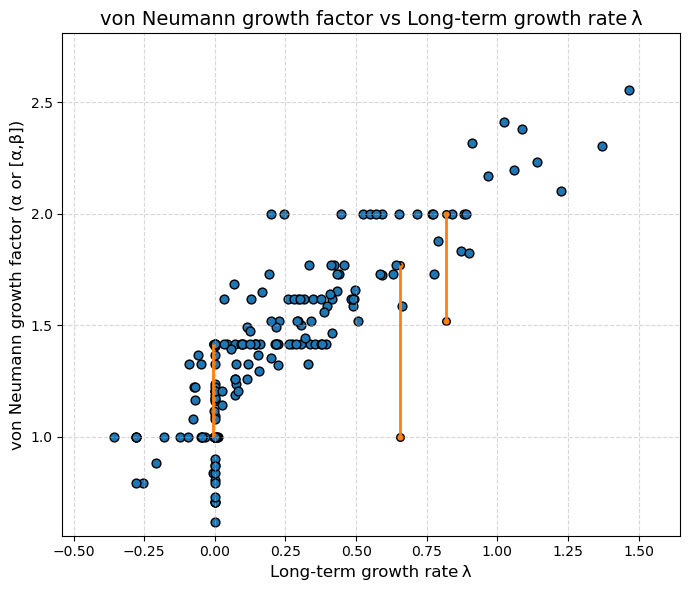

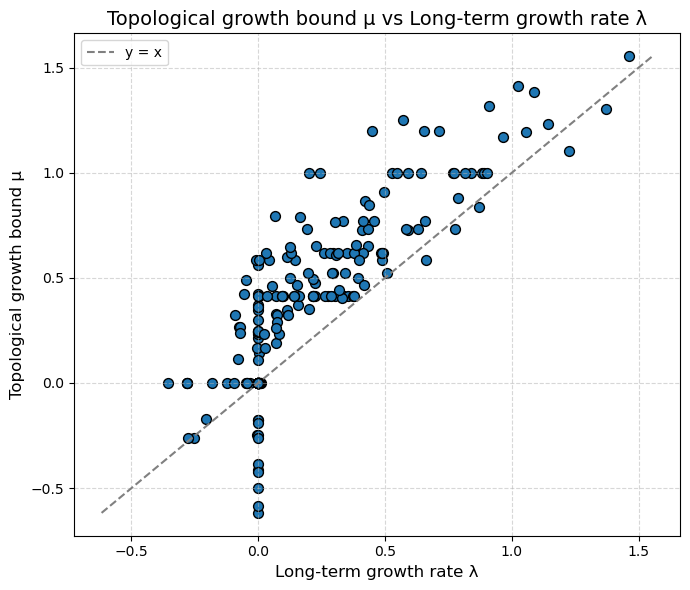

In [9]:
'''
Stoichometric autocatalytic and dynamic growth

Systems for chemical reaction order = 3
'''

def main_example():

    target_num = 200
    
    # storage
    alpha_list = []
    beta_list = []
    lambda_list = []
    mu_list = []
    
    attempts = 0       
    successes = 0       
    
    # number of trail
    while successes < target_num and attempts < 2500:
        attempts += 1
        
        # Random networks
        Stot, N_X, N_Y, N_R, S_plus, S_minus = Generate_Random_Network(
        N_X_raw=random.randint(3, 6),
        N_Y_raw=random.randint(3, 6),
        N_R_raw=random.randint(5, 10),
            diluted=False, ambiguity=False, autonomy=True
        )
        
        # Check autonomy condition
        S_plus_trim = S_plus[N_X:, :]
        S_minus_trim = S_minus[N_X:, :]
        _, _, auto = aux.checkAutonomy(S_minus_trim, S_plus_trim)
        if not auto:
            continue
        
        # von Neumann growth factor α, β
        try:
            alpha, beta, x_alpha, p_alpha, x_beta, p_beta = compute_von_neumann_alpha_beta(S_plus_trim, S_minus_trim)
        except Exception:
            continue
        if np.isnan(alpha) or np.isnan(beta):
            continue
        
        # Kinetics
        Y0, kf, kd = Construct_Kinetics(
            N_X, N_Y, N_R, S_plus, S_minus, degradation=False
        )
        
        # Simulation
        dt = 1e-3
        n_steps = 250000
        t_eval, Ystar_traj, Yabs_traj, mus, N_traj = Solve_Scaled_System(
            S_minus, S_plus, Y0, N_X, N_Y, N_R,
            kf, kd, law="MA", dt=dt, n_steps=n_steps
        )
        
        # long-term growth rate λ
        lambda_est = compute_long_term_growth_rate(mus, last_n=100)

        mu = compute_topological_growth_bound(S_minus_trim, alpha, x_alpha)
        
        # save
        alpha_list.append(alpha)
        beta_list.append(beta)
        lambda_list.append(lambda_est)
        mu_list.append(mu)
        successes += 1
        
        print(f"【{successes}/{target_num}】  α = {alpha:.5f},  β = {beta:.5f}, μ = {mu:.5f},  λ = {lambda_est:.5f}")
    
    # check loop

        print(f"collect {successes} effective (α, β, mu, λ), end")

    plt.figure(figsize=(7, 6))
    
    y_lo = []
    y_hi = []
    for a, b in zip(alpha_list, beta_list):
        y_lo.append(min(a, b))
        y_hi.append(max(a, b))
    
    λ_arr = np.array(lambda_list)
    y_lo_arr = np.array(y_lo)
    y_hi_arr = np.array(y_hi)
    
    λ_min = λ_arr.min()
    λ_max = λ_arr.max()
    
    λ_range = λ_max - λ_min
    x_min = λ_min - 0.1 * λ_range
    x_max = λ_max + 0.1 * λ_range
    
    y_min = y_lo_arr.min() * 0.9
    y_max = y_hi_arr.max() * 1.1
    
    for a, b, lam in zip(alpha_list, beta_list, lambda_list):
        if abs(a - b) < 1e-6:
            plt.scatter(lam, a, color='C0', edgecolors='k', s=40)
        else:
            lo = min(a, b)
            hi = max(a, b)
            plt.vlines(x=lam, ymin=lo, ymax=hi, color='C1', linewidth=2)
            plt.scatter([lam, lam], [lo, hi], color='C1', edgecolors='k', s=30)
    
    plt.xlabel("Long-term growth rate λ", fontsize=12)
    plt.ylabel("von Neumann growth factor (α or [α,β])", fontsize=12)
    plt.title("von Neumann growth factor vs Long-term growth rate λ", fontsize=14)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    plt.grid(linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # μ vs λ 
    plt.figure(figsize=(7, 6))
    plt.scatter(lambda_list, mu_list, marker='o', edgecolors='k', s=50)

    # reference line x = y
    all_vals = np.concatenate([lambda_list, mu_list])
    vmin, vmax = all_vals.min(), all_vals.max()
    plt.plot([vmin, vmax], [vmin, vmax], ls='--', color='gray', label='y = x')

    plt.xlabel("Long-term growth rate λ", fontsize=12)
    plt.ylabel("Topological growth bound μ", fontsize=12)
    plt.title("Topological growth bound μ vs Long-term growth rate λ", fontsize=14)
    plt.legend()
    plt.grid(linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()
    
if __name__ == "__main__":
   main_example()

